In [384]:
import numpy as np
import yfinance as yf
import pandas as pd
# import tulipy as ti
from math import asin, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
# from termcolor import colored as cl
from math import floor
from fredapi import Fred
# import investpy
import seaborn as sns
import itertools
from qiskit_aer import AerSimulator
from qiskit.providers.basic_provider import BasicProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from pgmpy.models import BayesianModel,BayesianNetwork
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.estimators import BicScore, K2Score#, BdeuScore
from pgmpy.estimators import HillClimbSearch
import networkx as nx
import pylab as plt
import pyfolio as pf

# import warnings
# import logging

In [385]:
### Qiskit Runtime service initialization
QiskitRuntimeService.save_account(channel = 'ibm_quantum',
                                  token = 'afbbd92eae66abcc98ea8bfd6269888a2fbeb2cc875b1f30c6cc67ced46d4b5ef84270be2de6c64361ec83180dd3f6f1c616db0debf34cdf5d7816ba9d374597',
                                  instance='ibm-q/open/main',
                                  overwrite=True)
service = QiskitRuntimeService(verify=False)

/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auth.quantum-computing.ibm.com'. Adding certificate verification is strongly advised. See: https://

In [386]:
######## utility functions ############
#### Utility functions for QBN ######

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))


def bit_str_2_arr(bitstring):
	my_state = bitstring[::-1]
	bit_array = np.zeros(len(my_state))
	for i in range(len(my_state)):
		if int(my_state[i]) == 0:
			pass
		else:
			bit_array[i] = int(my_state[i])
	return bit_array



def custom_mcry(circuit,angle,control_qubits,target,control_state):
	# Multi-coltrolled Ry gate #
	Id = []
	for i in range(len(control_state)):
		c = control_state[i]
		if c == '0':
			Id.append(control_qubits[i])			
		else:
			pass
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	circuit.mcry(angle,control_qubits,target)
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	return circuit

In [387]:
start_date = '2019-01-01'
end_date =   '2019-06-30'

In [388]:
# ^SOX > PHLX semiconductor data
# CNY=X > Yuan to USD forex rate
# EUR=X > EURO to USD forex rate
# ^TNX > CBOE Interest Rate 10 Year T No

target = 'BTC-USD'
tickers = [target,"^VIX","^NDX","GC=F","NVDA","^GSPC","CNY=X","EUR=X","^TNX"]

###### Stock Data Collection #######
###### The trading algoorithm will be designed for this Assets #############
data0 = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data0.dropna(inplace=True)
data0.head()

[*********************100%%**********************]  9 of 9 completed


Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,,,,
2019-01-02,3943.409424,6.8775,0.87247,1281.000000,3.378612,2510.030029,6360.870117,2.661,23.219999
2019-01-03,3836.741211,6.8611,0.88354,1291.800049,3.174487,2447.889893,6147.129883,2.554,25.450001
2019-01-04,3857.717529,6.8711,0.87788,1282.699951,3.377868,2531.939941,6422.669922,2.659,21.379999
2019-01-07,4025.248291,6.8684,0.87639,1286.800049,3.556694,2549.689941,6488.250000,2.682,21.400000
2019-01-08,4030.847900,6.8500,0.87110,1283.199951,3.468149,2574.409912,6551.850098,2.716,20.469999


In [389]:
data0.shape

(123, 9)

In [390]:
# fred = Fred(api_key='8bd22ac3ad2b9cdcbe7c4d5bb66e94ae')

# # 'DCOILWTICO' > West Texas Intermediate (WTI) - Cushing, Oklahoma - crude oil
# # DFF' > Federal fund rate
# series_ids = ['DCOILWTICO'] # ,'DFF']

# data1 = pd.DataFrame()

# # Loop through each series ID and fetch the data
# for series_id in series_ids:
#     df = fred.get_series(series_id)
#     data1[series_id] = df

# # Filter the DataFrame to include data only from 2010 to 2020
# data1 = data1.loc[data0.index]
# data1.head()

In [391]:
##### Joining two dataframes #####
data = data0
# data = pd.concat([data0,data1],axis=1)
# data.head()

In [392]:
####### removing NaN vaalues from the data set ################
data = data.dropna()
print("Number of available samples are",data.shape[0])
print("Number of NaN value on each columns are:\n",data.isna().sum())
data.head()

Number of available samples are 123
Number of NaN value on each columns are:
 Ticker
BTC-USD    0
CNY=X      0
EUR=X      0
GC=F       0
NVDA       0
^GSPC      0
^NDX       0
^TNX       0
^VIX       0
dtype: int64


Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,,,,
2019-01-02,3943.409424,6.8775,0.87247,1281.000000,3.378612,2510.030029,6360.870117,2.661,23.219999
2019-01-03,3836.741211,6.8611,0.88354,1291.800049,3.174487,2447.889893,6147.129883,2.554,25.450001
2019-01-04,3857.717529,6.8711,0.87788,1282.699951,3.377868,2531.939941,6422.669922,2.659,21.379999
2019-01-07,4025.248291,6.8684,0.87639,1286.800049,3.556694,2549.689941,6488.250000,2.682,21.400000
2019-01-08,4030.847900,6.8500,0.87110,1283.199951,3.468149,2574.409912,6551.850098,2.716,20.469999


In [393]:
###### Converting to Percentage changes data ##########
data = data.pct_change().dropna()
data.head()

Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,,,,
2019-01-03,-0.027050,-0.002385,0.012688,0.008431,-0.060417,-0.024757,-0.033602,-0.040210,0.096038
2019-01-04,0.005467,0.001457,-0.006406,-0.007045,0.064067,0.034336,0.044824,0.041112,-0.159921
2019-01-07,0.043427,-0.000393,-0.001697,0.003196,0.052941,0.007010,0.010211,0.008650,0.000935
2019-01-08,0.001391,-0.002679,-0.006036,-0.002798,-0.024895,0.009695,0.009802,0.012677,-0.043458
2019-01-09,0.001104,0.000321,0.002066,0.004754,0.019667,0.004098,0.007454,0.004418,-0.023937


In [394]:
transformed_df = data.apply(lambda x: (x + (0.5-data.mean())),axis=1)
transformed_df.head()

Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,,,,
2019-01-03,0.462637,0.497625,0.512618,0.507623,0.437613,0.473910,0.464801,0.462007,0.597141
2019-01-04,0.495154,0.501467,0.493524,0.492148,0.562098,0.533002,0.543227,0.543329,0.341181
2019-01-07,0.533114,0.499617,0.498233,0.502389,0.550971,0.505677,0.508614,0.510867,0.502038
2019-01-08,0.491078,0.497330,0.493894,0.496394,0.473135,0.508362,0.508205,0.514895,0.457645
2019-01-09,0.490790,0.500331,0.501997,0.503946,0.517697,0.502764,0.505857,0.506636,0.477165


In [395]:
####### The Quantum Data ##############
q_data = 2*np.arctan(np.sqrt((transformed_df)/(1-transformed_df)))
q_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,,,,
2019-01-03,1.496000,1.566046,1.596036,1.586043,1.445697,1.518592,1.500339,1.494737,1.766322
2019-01-04,1.561104,1.573730,1.557845,1.555091,1.695314,1.636849,1.657359,1.657564,1.247560
2019-01-07,1.637073,1.570029,1.567262,1.575573,1.672916,1.582150,1.588025,1.592533,1.574873
2019-01-08,1.552951,1.565457,1.558585,1.563585,1.517041,1.587520,1.587208,1.600590,1.485985
2019-01-09,1.552376,1.571458,1.574790,1.578688,1.606198,1.576325,1.582511,1.584068,1.525111


In [396]:
############## Data Discretization with Quantum Measurement ##############

DATA_STATES = []

k = 0
y = 20
 
backend = AerSimulator()

for i in range(k,q_data.shape[0]):
    circ = QuantumCircuit(q_data.shape[1])   
    for j in range(q_data.shape[1]):
        theta = q_data.iloc[i,j]
        # circ.ry(theta,j)
        if theta > np.pi/2:
            theta_prime = np.pi #theta + np.pi/y + (theta - np.pi/2)
            circ.ry(theta_prime,j)
            # circ.ry(np.pi - (theta - np.pi/2),j)

        elif theta < np.pi/2:
            theta_prime = 0 #theta - np.pi/y - (np.pi/2 - theta)
            circ.ry(theta_prime,j)
            # circ.ry((theta - np.pi/2),j)

        else:
            theta_prime = theta
            circ.ry(theta,j)
        print("Theta is {} and Theta_Prime is {}".format(theta,theta_prime))

    circ.measure_all()
    # pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    # isa_circuit = pm.run(circ) 

    with Session(service, backend = backend) as session:
        sampler = Sampler(session=session)

        job = sampler.run(circ, shots=1000)
        result = job.result()
        binary_data = result.quasi_dists[0].binary_probabilities()
        state = max(zip(binary_data.values(), binary_data.keys()))[1]
        DATA_STATES.append(bit_str_2_arr(state))
    print(f"Job result: {state}")

/tmp/ipykernel_14007/3324779740.py:35: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)
base_primitive._run_primitive:INFO:2024-07-17 16:53:37,146: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02503 

Theta is 1.4960001385959663 and Theta_Prime is 0
Theta is 1.5660460788597241 and Theta_Prime is 0
Theta is 1.596035800210699 and Theta_Prime is 3.141592653589793
Theta is 1.5860429634844093 and Theta_Prime is 3.141592653589793
Theta is 1.4456971791724782 and Theta_Prime is 0
Theta is 1.5185919679961337 and Theta_Prime is 0
Theta is 1.500339300945572 and Theta_Prime is 0
Theta is 1.4947370043587824 and Theta_Prime is 0
Theta is 1.7663215988904526 and Theta_Prime is 3.141592653589793
Job result: 100001100
Theta is 1.5611036401372362 and Theta_Prime is 0
Theta is 1.5737301472531555 and Theta_Prime is 3.141592653589793
Theta is 1.5578445436976471 and Theta_Prime is 0
Theta is 1.5550908052913195 and Theta_Prime is 0
Theta is 1.6953135389566119 and Theta_Prime is 3.141592653589793
Theta is 1.6368485863225601 and Theta_Prime is 3.141592653589793
Theta is 1.6573587125763647 and Theta_Prime is 3.141592653589793
Theta is 1.657564109432195 and Theta_Prime is 3.141592653589793
Theta is 1.247559890

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.27602 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011110010
Theta is 1.6370727184495768 and Theta_Prime is 3.141592653589793
Theta is 1.570029373564588 and Theta_Prime is 0
Theta is 1.5672624554201444 and Theta_Prime is 0
Theta is 1.5755734057936717 and Theta_Prime is 3.141592653589793
Theta is 1.6729156853344003 and Theta_Prime is 3.141592653589793
Theta is 1.5821502512401957 and Theta_Prime is 3.141592653589793
Theta is 1.588024586378897 and Theta_Prime is 3.141592653589793
Theta is 1.5925327461502148 and Theta_Prime is 3.141592653589793
Theta is 1.574873186282851 and Theta_Prime is 3.141592653589793
Job result: 111111001
Theta is 1.5529506424204373 and Theta_Prime is 0
Theta is 1.5654572788263972 and Theta_Prime is 0
Theta is 1.5585845067799597 and Theta_Prime is 0
Theta is 1.5635849806809963 and Theta_Prime is 0
Theta is 1.5170405525561776 and Theta_Prime is 0
Theta is 1.5875204872558926 and Theta_Prime is 3.141592653589793
Theta is 1.587207732794474 and Theta_Prime is 3.141592653589793
Theta is 1.6005900355271367 and 

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.33998 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011100000
Theta is 1.5523755260240073 and Theta_Prime is 0
Theta is 1.5714576037300185 and Theta_Prime is 3.141592653589793
Theta is 1.5747897150998225 and Theta_Prime is 3.141592653589793
Theta is 1.5786881856386865 and Theta_Prime is 3.141592653589793
Theta is 1.606197607106632 and Theta_Prime is 3.141592653589793
Theta is 1.57632525667237 and Theta_Prime is 3.141592653589793
Theta is 1.5825112822955372 and Theta_Prime is 3.141592653589793
Theta is 1.5840680957345625 and Theta_Prime is 3.141592653589793
Theta is 1.5251114166043298 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:38,078: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03457 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.62943 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011111110
Theta is 1.3722399100941889 and Theta_Prime is 0
Theta is 1.5601322954532675 and Theta_Prime is 0
Theta is 1.553540751672388 and Theta_Prime is 0
Theta is 1.5620445519088804 and Theta_Prime is 0
Theta is 1.6040353850147082 and Theta_Prime is 3.141592653589793
Theta is 1.5771660182409697 and Theta_Prime is 3.141592653589793
Theta is 1.573738022500935 and Theta_Prime is 3.141592653589793
Theta is 1.5774307734519772 and Theta_Prime is 3.141592653589793
Theta is 1.5249381499876455 and Theta_Prime is 0
Job result: 011110000
Theta is 1.5547574554500077 and Theta_Prime is 0
Theta is 1.562569344923743 and Theta_Prime is 0
Theta is 1.5784450778093206 and Theta_Prime is 3.141592653589793
Theta is 1.572916790435907 and Theta_Prime is 3.141592653589793
Theta is 1.6164501766965962 and Theta_Prime is 3.141592653589793
Theta is 1.5678365375970296 and Theta_Prime is 0
Theta is 1.561699673575615 and Theta_Prime is 0
Theta is 1.553260443283281 and Theta_Prime is 0
Theta is 1.438255

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.47207 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 000011100
Theta is 1.5603047199024138 and Theta_Prime is 0
Theta is 1.5633014013287014 and Theta_Prime is 0
Theta is 1.5793818287760346 and Theta_Prime is 3.141592653589793
Theta is 1.572288232100719 and Theta_Prime is 3.141592653589793
Theta is 1.5884930822904784 and Theta_Prime is 3.141592653589793
Theta is 1.5576137054538701 and Theta_Prime is 0
Theta is 1.5493136547999569 and Theta_Prime is 0
Theta is 1.581895768866102 and Theta_Prime is 3.141592653589793
Theta is 1.669920836881768 and Theta_Prime is 3.141592653589793
Job result: 110011100
Theta is 1.5094531209325532 and Theta_Prime is 0
Theta is 1.572323593943184 and Theta_Prime is 3.141592653589793
Theta is 1.5684337149399208 and Theta_Prime is 0
Theta is 1.5646811307254826 and Theta_Prime is 0
Theta is 1.5592791936967763 and Theta_Prime is 0
Theta is 1.5895736182658786 and Theta_Prime is 3.141592653589793
Theta is 1.6069311530860095 and Theta_Prime is 3.141592653589793
Theta is 1.5759692728005918 and Theta_Prime is 3

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.39840 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011100010
Theta is 1.5635725991920042 and Theta_Prime is 0
Theta is 1.566056917860589 and Theta_Prime is 0
Theta is 1.5804778756748794 and Theta_Prime is 3.141592653589793
Theta is 1.5775773879691004 and Theta_Prime is 3.141592653589793
Theta is 1.553110881593125 and Theta_Prime is 0
Theta is 1.5725731095134157 and Theta_Prime is 3.141592653589793
Theta is 1.567278409792308 and Theta_Prime is 0
Theta is 1.5899871629656719 and Theta_Prime is 3.141592653589793
Theta is 1.6203343678338757 and Theta_Prime is 3.141592653589793
Job result: 110101100
Theta is 1.563059603175864 and Theta_Prime is 0
Theta is 1.5722965274462346 and Theta_Prime is 3.141592653589793
Theta is 1.5739451592128333 and Theta_Prime is 3.141592653589793
Theta is 1.5682514246828427 and Theta_Prime is 0
Theta is 1.6055631828904564 and Theta_Prime is 3.141592653589793
Theta is 1.5833122651317793 and Theta_Prime is 3.141592653589793
Theta is 1.5825653591670892 and Theta_Prime is 3.141592653589793
Theta is 1.58841

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.46325 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011110110
Theta is 1.5388961649037716 and Theta_Prime is 0
Theta is 1.576558341457294 and Theta_Prime is 3.141592653589793
Theta is 1.5716143782987029 and Theta_Prime is 3.141592653589793
Theta is 1.5541526663272798 and Theta_Prime is 0
Theta is 1.6355813454093338 and Theta_Prime is 3.141592653589793
Theta is 1.5944974626324375 and Theta_Prime is 3.141592653589793
Theta is 1.5872979644557315 and Theta_Prime is 3.141592653589793
Theta is 1.600699445530442 and Theta_Prime is 3.141592653589793
Theta is 1.5442061527284876 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:39,522: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.53644 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011110110
Theta is 1.5210265791769466 and Theta_Prime is 0
Theta is 1.5772797506669123 and Theta_Prime is 3.141592653589793
Theta is 1.5747583580265125 and Theta_Prime is 3.141592653589793
Theta is 1.5710534912037781 and Theta_Prime is 3.141592653589793
Theta is 1.4626509082948316 and Theta_Prime is 0
Theta is 1.5398095667036333 and Theta_Prime is 0
Theta is 1.5269669739150058 and Theta_Prime is 0
Theta is 1.5364314991288919 and Theta_Prime is 0
Theta is 1.9169525710703605 and Theta_Prime is 3.141592653589793
Job result: 100001110
Theta is 1.5393700638481287 and Theta_Prime is 0
Theta is 1.5736693971243663 and Theta_Prime is 3.141592653589793
Theta is 1.5715893279092865 and Theta_Prime is 3.141592653589793
Theta is 1.5701161042431961 and Theta_Prime is 0
Theta is 1.573848224985107 and Theta_Prime is 3.141592653589793
Theta is 1.572534964026702 and Theta_Prime is 3.141592653589793
Theta is 1.5711979176768862 and Theta_Prime is 3.141592653589793
Theta is 1.5935483468001277 an

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.34904 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011110110
Theta is 1.5589511568759307 and Theta_Prime is 0
Theta is 1.5661140913093974 and Theta_Prime is 0
Theta is 1.5664067561939057 and Theta_Prime is 0
Theta is 1.5629454892347587 and Theta_Prime is 0
Theta is 1.6816260350520733 and Theta_Prime is 3.141592653589793
Theta is 1.5708805887111392 and Theta_Prime is 3.141592653589793
Theta is 1.580755071818877 and Theta_Prime is 3.141592653589793
Theta is 1.5440119631545985 and Theta_Prime is 0
Theta is 1.5084124806625538 and Theta_Prime is 0
Job result: 001110000
Theta is 1.5495570025467529 and Theta_Prime is 0
Theta is 1.569813949960056 and Theta_Prime is 0
Theta is 1.583867730272448 and Theta_Prime is 3.141592653589793
Theta is 1.5977976967539265 and Theta_Prime is 3.141592653589793
Theta is 1.5961296425679046 and Theta_Prime is 3.141592653589793
Theta is 1.58510701418012 and Theta_Prime is 3.141592653589793
Theta is 1.592913963420115 and Theta_Prime is 3.141592653589793
Theta is 1.605474329484896 and Theta_Prime is 3.14

INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07486 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.70994 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.20194 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.12445 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.10133 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 115.07297 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:40,095: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': 

Job result: 011111100
Theta is 1.4781904631048763 and Theta_Prime is 0
Theta is 1.5586751024406413 and Theta_Prime is 0
Theta is 1.5532107234223584 and Theta_Prime is 0
Theta is 1.5768882305268537 and Theta_Prime is 3.141592653589793
Theta is 1.2865545165012586 and Theta_Prime is 0
Theta is 1.5524344508214367 and Theta_Prime is 0
Theta is 1.5409954539941908 and Theta_Prime is 0
Theta is 1.5686929267919671 and Theta_Prime is 0
Theta is 1.7402879720169224 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:40,349: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03290 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.32663 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100001000
Theta is 1.5372924176080316 and Theta_Prime is 0
Theta is 1.5701926793441348 and Theta_Prime is 0
Theta is 1.5676896511370721 and Theta_Prime is 0
Theta is 1.5780870557099558 and Theta_Prime is 3.141592653589793
Theta is 1.473813508691829 and Theta_Prime is 0
Theta is 1.5652166154949125 and Theta_Prime is 0
Theta is 1.548398111181535 and Theta_Prime is 0
Theta is 1.5519065096929638 and Theta_Prime is 0
Theta is 1.6005634101185706 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:40,579: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02813 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.46992 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100001000
Theta is 1.572247889097355 and Theta_Prime is 3.141592653589793
Theta is 1.5671676940306911 and Theta_Prime is 0
Theta is 1.5697196898351953 and Theta_Prime is 0
Theta is 1.5717795730630484 and Theta_Prime is 3.141592653589793
Theta is 1.6549504649883608 and Theta_Prime is 3.141592653589793
Theta is 1.599231491202889 and Theta_Prime is 3.141592653589793
Theta is 1.6204270288352514 and Theta_Prime is 3.141592653589793
Theta is 1.5626943631011985 and Theta_Prime is 0
Theta is 1.4187316066283397 and Theta_Prime is 0
Job result: 001111001
Theta is 1.5338744197493699 and Theta_Prime is 0
Theta is 1.5659132517806187 and Theta_Prime is 0
Theta is 1.5615543569535324 and Theta_Prime is 0
Theta is 1.5841437283289654 and Theta_Prime is 3.141592653589793
Theta is 1.6595562054627817 and Theta_Prime is 3.141592653589793
Theta is 1.5853244405597295 and Theta_Prime is 3.141592653589793
Theta is 1.5966683411711657 and Theta_Prime is 3.141592653589793
Theta is 1.5306936874170587 an

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.43893 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 001111000
Theta is 1.5676097087377372 and Theta_Prime is 0
Theta is 1.5661395045543087 and Theta_Prime is 0
Theta is 1.5773197538566193 and Theta_Prime is 3.141592653589793
Theta is 1.5649371585219425 and Theta_Prime is 0
Theta is 1.5804921582289524 and Theta_Prime is 3.141592653589793
Theta is 1.5699263576788611 and Theta_Prime is 0
Theta is 1.5585327688687227 and Theta_Prime is 0
Theta is 1.6177532899343634 and Theta_Prime is 3.141592653589793
Theta is 1.5210806835889266 and Theta_Prime is 0
Job result: 010010100
Theta is 1.5336517970511334 and Theta_Prime is 0
Theta is 1.5839503750865112 and Theta_Prime is 3.141592653589793
Theta is 1.5696494368547238 and Theta_Prime is 0
Theta is 1.5652318109637366 and Theta_Prime is 0
Theta is 1.6283831240056281 and Theta_Prime is 3.141592653589793
Theta is 1.581681825813728 and Theta_Prime is 3.141592653589793
Theta is 1.592166411246111 and Theta_Prime is 3.141592653589793
Theta is 1.5997615388109958 and Theta_Prime is 3.1415926535897

INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.23007 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.12016 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06747 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02909 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.53399 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.19574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.15712 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06127 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 011110010
Theta is 1.554333418473928 and Theta_Prime is 0
Theta is 1.5708152309289551 and Theta_Prime is 3.141592653589793
Theta is 1.573979038518349 and Theta_Prime is 3.141592653589793
Theta is 1.5690281480732298 and Theta_Prime is 0
Theta is 1.5771794876762593 and Theta_Prime is 3.141592653589793
Theta is 1.5775460296071875 and Theta_Prime is 3.141592653589793
Theta is 1.5858673562757255 and Theta_Prime is 3.141592653589793
Theta is 1.5590782563332803 and Theta_Prime is 0
Theta is 1.5526579558700353 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07129 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02623 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 196.57254 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:41,487: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthes

Job result: 001110110
Theta is 1.519804391148673 and Theta_Prime is 0
Theta is 1.5681460202153772 and Theta_Prime is 0
Theta is 1.575277273813575 and Theta_Prime is 3.141592653589793
Theta is 1.5620277911425349 and Theta_Prime is 0
Theta is 1.6075461780806657 and Theta_Prime is 3.141592653589793
Theta is 1.5636802015827094 and Theta_Prime is 0
Theta is 1.560226907806379 and Theta_Prime is 0
Theta is 1.57523131038902 and Theta_Prime is 3.141592653589793
Theta is 1.548594545425517 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 181.12493 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:41,745: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.50306 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measur

Job result: 010010100
Theta is 1.5417896993025089 and Theta_Prime is 0
Theta is 1.5734880088854188 and Theta_Prime is 3.141592653589793
Theta is 1.5783930315570973 and Theta_Prime is 3.141592653589793
Theta is 1.5690277761696807 and Theta_Prime is 0
Theta is 1.4938400795592246 and Theta_Prime is 0
Theta is 1.5494132278279618 and Theta_Prime is 0
Theta is 1.5411203280165988 and Theta_Prime is 0
Theta is 1.538215943705589 and Theta_Prime is 0
Theta is 1.7021180635357043 and Theta_Prime is 3.141592653589793
Job result: 100000110
Theta is 1.7078629140756154 and Theta_Prime is 3.141592653589793
Theta is 1.5708152309289551 and Theta_Prime is 3.141592653589793
Theta is 1.5754534598062755 and Theta_Prime is 3.141592653589793
Theta is 1.5757482717899578 and Theta_Prime is 3.141592653589793
Theta is 1.5770319858703101 and Theta_Prime is 3.141592653589793
Theta is 1.5694815393974197 and Theta_Prime is 0
Theta is 1.5699628827460126 and Theta_Prime is 0
Theta is 1.56014815247284 and Theta_Prime is 

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03624 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.47874 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 000011111
Theta is 1.5401559847904769 and Theta_Prime is 0
Theta is 1.5708152309289551 and Theta_Prime is 3.141592653589793
Theta is 1.5732195269200953 and Theta_Prime is 3.141592653589793
Theta is 1.5589800709269912 and Theta_Prime is 0
Theta is 1.5436368082212788 and Theta_Prime is 0
Theta is 1.5695473434748484 and Theta_Prime is 0
Theta is 1.5664596141804121 and Theta_Prime is 0
Theta is 1.5972708961801505 and Theta_Prime is 3.141592653589793
Theta is 1.6048154012582379 and Theta_Prime is 3.141592653589793
Job result: 110000110
Theta is 1.5529629730322523 and Theta_Prime is 0
Theta is 1.5849323099548631 and Theta_Prime is 3.141592653589793
Theta is 1.5786747426362524 and Theta_Prime is 3.141592653589793
Theta is 1.572546884170643 and Theta_Prime is 3.141592653589793
Theta is 1.6313528255387557 and Theta_Prime is 3.141592653589793
Theta is 1.5939116455235898 and Theta_Prime is 3.141592653589793
Theta is 1.5981418148666913 and Theta_Prime is 3.141592653589793
Theta is 1.59

INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 13.08966 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.12851 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.04792 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04530 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 3.07560 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03362 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.23985 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.14257 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06533 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 4.23574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.08559 (ms)
INFO:qiskit.passmanage

Job result: 011111110
Theta is 1.538417232362947 and Theta_Prime is 0
Theta is 1.5653965303702553 and Theta_Prime is 0
Theta is 1.5608440504010905 and Theta_Prime is 0
Theta is 1.571624859981936 and Theta_Prime is 3.141592653589793
Theta is 1.5894822684096355 and Theta_Prime is 3.141592653589793
Theta is 1.5741771333801837 and Theta_Prime is 3.141592653589793
Theta is 1.5679472723239503 and Theta_Prime is 0
Theta is 1.5931168520734609 and Theta_Prime is 3.141592653589793
Theta is 1.601522847986024 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02956 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.18716 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11158 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.09823 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 225.92998 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:42,705: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Job result: 110111000
Theta is 1.5418010757318814 and Theta_Prime is 0
Theta is 1.566799312102486 and Theta_Prime is 0
Theta is 1.5830346656163912 and Theta_Prime is 3.141592653589793
Theta is 1.5676546789628223 and Theta_Prime is 0
Theta is 1.5884434495523516 and Theta_Prime is 3.141592653589793
Theta is 1.5628257700977668 and Theta_Prime is 0
Theta is 1.5694666488395423 and Theta_Prime is 0
Theta is 1.537559090261129 and Theta_Prime is 0
Theta is 1.6459162684031161 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:42,946: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.44155 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100010100
Theta is 1.5523414044820483 and Theta_Prime is 0
Theta is 1.5743067579023093 and Theta_Prime is 3.141592653589793
Theta is 1.565272400949617 and Theta_Prime is 0
Theta is 1.5818542735400043 and Theta_Prime is 3.141592653589793
Theta is 1.6032309535095932 and Theta_Prime is 3.141592653589793
Theta is 1.589887802556014 and Theta_Prime is 3.141592653589793
Theta is 1.5769325239218774 and Theta_Prime is 3.141592653589793
Theta is 1.582005956128735 and Theta_Prime is 3.141592653589793
Theta is 1.4107914514872208 and Theta_Prime is 0
Job result: 011111010
Theta is 1.731081657407695 and Theta_Prime is 3.141592653589793
Theta is 1.5691906093523607 and Theta_Prime is 0
Theta is 1.5677201178006934 and Theta_Prime is 0
Theta is 1.6025671973519477 and Theta_Prime is 3.141592653589793
Theta is 1.5579587940252795 and Theta_Prime is 0
Theta is 1.5711266242512156 and Theta_Prime is 3.141592653589793
Theta is 1.570842379830193 and Theta_Prime is 3.141592653589793
Theta is 1.560977

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.52857 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 001101001
Theta is 1.5768857826164608 and Theta_Prime is 3.141592653589793
Theta is 1.568450389317945 and Theta_Prime is 0
Theta is 1.565182094629313 and Theta_Prime is 0
Theta is 1.573956347511137 and Theta_Prime is 3.141592653589793
Theta is 1.5912459407407977 and Theta_Prime is 3.141592653589793
Theta is 1.5716833592261727 and Theta_Prime is 3.141592653589793
Theta is 1.5663937759992685 and Theta_Prime is 0
Theta is 1.5805204323141615 and Theta_Prime is 3.141592653589793
Theta is 1.4571665053214782 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:43,591: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27347 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 010111001
Theta is 1.527303414382558 and Theta_Prime is 0
Theta is 1.5597462196257863 and Theta_Prime is 0
Theta is 1.570067170807219 and Theta_Prime is 0
Theta is 1.5396957451224853 and Theta_Prime is 0
Theta is 1.5317793467407568 and Theta_Prime is 0
Theta is 1.5610761109560705 and Theta_Prime is 0
Theta is 1.559905003505995 and Theta_Prime is 0
Theta is 1.6008574655122574 and Theta_Prime is 3.141592653589793
Theta is 1.6358154393689421 and Theta_Prime is 3.141592653589793
Job result: 110000000
Theta is 1.5761718566009728 and Theta_Prime is 3.141592653589793
Theta is 1.5704580447576266 and Theta_Prime is 0
Theta is 1.5712469975807382 and Theta_Prime is 3.141592653589793
Theta is 1.577793977921276 and Theta_Prime is 3.141592653589793
Theta is 1.6107787042524464 and Theta_Prime is 3.141592653589793
Theta is 1.5809515169386026 and Theta_Prime is 3.141592653589793
Theta is 1.583371913568835 and Theta_Prime is 3.141592653589793
Theta is 1.5506763723264607 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.41676 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 001111101
Theta is 1.488746892892953 and Theta_Prime is 0
Theta is 1.569059070402826 and Theta_Prime is 0
Theta is 1.5707930277798505 and Theta_Prime is 0
Theta is 1.564215139651418 and Theta_Prime is 0
Theta is 1.560574983131946 and Theta_Prime is 0
Theta is 1.5705928627407308 and Theta_Prime is 0
Theta is 1.5745975350510892 and Theta_Prime is 3.141592653589793
Theta is 1.5887916840913574 and Theta_Prime is 3.141592653589793
Theta is 1.7727436851672769 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:44,205: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25368 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 111000000
Theta is 1.5355647906393692 and Theta_Prime is 0
Theta is 1.5634266459985884 and Theta_Prime is 0
Theta is 1.5662108691148946 and Theta_Prime is 0
Theta is 1.5679736649689986 and Theta_Prime is 0
Theta is 1.546815637039023 and Theta_Prime is 0
Theta is 1.566548210631259 and Theta_Prime is 0
Theta is 1.5697919144414334 and Theta_Prime is 0
Theta is 1.547544817770952 and Theta_Prime is 0
Theta is 1.616115336793518 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:44,424: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.42677 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100000000
Theta is 1.5484496666443417 and Theta_Prime is 0
Theta is 1.5740448168019041 and Theta_Prime is 3.141592653589793
Theta is 1.5661554307511945 and Theta_Prime is 0
Theta is 1.5580111161071393 and Theta_Prime is 0
Theta is 1.5453399033646626 and Theta_Prime is 0
Theta is 1.5670410300004995 and Theta_Prime is 0
Theta is 1.5658558144551402 and Theta_Prime is 0
Theta is 1.6184968503114183 and Theta_Prime is 3.141592653589793
Theta is 1.5110021619860154 and Theta_Prime is 0
Job result: 010000010
Theta is 1.5521095684588242 and Theta_Prime is 0
Theta is 1.5669341575745435 and Theta_Prime is 0
Theta is 1.5729356005172315 and Theta_Prime is 3.141592653589793
Theta is 1.561743292956416 and Theta_Prime is 0
Theta is 1.554102153103292 and Theta_Prime is 0
Theta is 1.5624780250425865 and Theta_Prime is 0
Theta is 1.5621307207093733 and Theta_Prime is 0
Theta is 1.58860014352384 and Theta_Prime is 3.141592653589793
Theta is 1.5838869420807757 and Theta_Prime is 3.14159265358979

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.37551 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 110000100
Theta is 1.5526579017322548 and Theta_Prime is 0
Theta is 1.5728491822172646 and Theta_Prime is 3.141592653589793
Theta is 1.5718405164585205 and Theta_Prime is 3.141592653589793
Theta is 1.5441925301204282 and Theta_Prime is 0
Theta is 1.595253435874341 and Theta_Prime is 3.141592653589793
Theta is 1.5819200081882685 and Theta_Prime is 3.141592653589793
Theta is 1.5828304307392034 and Theta_Prime is 3.141592653589793
Theta is 1.6077001286719068 and Theta_Prime is 3.141592653589793
Theta is 1.4085566381295804 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:45,049: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03910 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.40245 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011110110
Theta is 1.4993120131320188 and Theta_Prime is 0
Theta is 1.5745206483526495 and Theta_Prime is 3.141592653589793
Theta is 1.570224896719542 and Theta_Prime is 0
Theta is 1.5512835584367093 and Theta_Prime is 0
Theta is 1.571075802942428 and Theta_Prime is 3.141592653589793
Theta is 1.5603678315957321 and Theta_Prime is 0
Theta is 1.5673954129100178 and Theta_Prime is 0
Theta is 1.5512734463281075 and Theta_Prime is 0
Theta is 1.7298996658393402 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:45,294: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.76365 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.51522 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100010010
Theta is 1.6218735006855949 and Theta_Prime is 3.141592653589793
Theta is 1.5710836091710005 and Theta_Prime is 3.141592653589793
Theta is 1.5774598617184739 and Theta_Prime is 3.141592653589793
Theta is 1.5648217034217111 and Theta_Prime is 0
Theta is 1.5635402393509643 and Theta_Prime is 0
Theta is 1.565866051982258 and Theta_Prime is 0
Theta is 1.5692692238544954 and Theta_Prime is 0
Theta is 1.57523131038902 and Theta_Prime is 3.141592653589793
Theta is 1.5880406262691187 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.36025 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.15306 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06914 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 188.94672 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:45,569: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02289 (ms)


Job result: 110000111
Theta is 1.5540530092401426 and Theta_Prime is 0
Theta is 1.570904820544735 and Theta_Prime is 3.141592653589793
Theta is 1.5760082208548185 and Theta_Prime is 3.141592653589793
Theta is 1.5737046930084577 and Theta_Prime is 3.141592653589793
Theta is 1.5097016764778077 and Theta_Prime is 0
Theta is 1.5550802933428889 and Theta_Prime is 0
Theta is 1.5552162739566577 and Theta_Prime is 0
Theta is 1.5531877902679179 and Theta_Prime is 0
Theta is 1.7091281948544537 and Theta_Prime is 3.141592653589793
Job result: 100001110
Theta is 1.5540322186597608 and Theta_Prime is 0
Theta is 1.5720974430081736 and Theta_Prime is 3.141592653589793
Theta is 1.569435789030387 and Theta_Prime is 0
Theta is 1.5674683062427124 and Theta_Prime is 0
Theta is 1.5301477016715692 and Theta_Prime is 0
Theta is 1.5518765737619682 and Theta_Prime is 0
Theta is 1.5435312371046201 and Theta_Prime is 0
Theta is 1.5336179796736475 and Theta_Prime is 0
Theta is 1.681231698261413 and Theta_Prime is

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.53334 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 100000010
Theta is 1.5448729115585986 and Theta_Prime is 0
Theta is 1.5717689196336992 and Theta_Prime is 3.141592653589793
Theta is 1.591317820612337 and Theta_Prime is 3.141592653589793
Theta is 1.5897454777671467 and Theta_Prime is 3.141592653589793
Theta is 1.5853487175913992 and Theta_Prime is 3.141592653589793
Theta is 1.5638657044212567 and Theta_Prime is 0
Theta is 1.5644173565998671 and Theta_Prime is 0
Theta is 1.5668853690925477 and Theta_Prime is 0
Theta is 1.507861119603702 and Theta_Prime is 0
Job result: 000011110
Theta is 1.5522680378818923 and Theta_Prime is 0
Theta is 1.5727515287007694 and Theta_Prime is 3.141592653589793
Theta is 1.5645874945113336 and Theta_Prime is 0
Theta is 1.5565354973993755 and Theta_Prime is 0
Theta is 1.7066796328083063 and Theta_Prime is 3.141592653589793
Theta is 1.5974643822130572 and Theta_Prime is 3.141592653589793
Theta is 1.60989750223418 and Theta_Prime is 3.141592653589793
Theta is 1.5889464923386993 and Theta_Prime is 3

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02789 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.45729 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011110010
Theta is 1.552180423248238 and Theta_Prime is 0
Theta is 1.5722734282176376 and Theta_Prime is 3.141592653589793
Theta is 1.5658943905689786 and Theta_Prime is 0
Theta is 1.5808193709391547 and Theta_Prime is 3.141592653589793
Theta is 1.5839858166069354 and Theta_Prime is 3.141592653589793
Theta is 1.5740357796773827 and Theta_Prime is 3.141592653589793
Theta is 1.5780042739944926 and Theta_Prime is 3.141592653589793
Theta is 1.5464737937211672 and Theta_Prime is 0
Theta is 1.4947713741370814 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:46,456: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03767 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.39506 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001111010
Theta is 1.5489197801152035 and Theta_Prime is 0
Theta is 1.5654921847814485 and Theta_Prime is 0
Theta is 1.5656579315999088 and Theta_Prime is 0
Theta is 1.586460985125285 and Theta_Prime is 3.141592653589793
Theta is 1.641985002421857 and Theta_Prime is 3.141592653589793
Theta is 1.5820285414094903 and Theta_Prime is 3.141592653589793
Theta is 1.5830721311439668 and Theta_Prime is 3.141592653589793
Theta is 1.579837977138747 and Theta_Prime is 3.141592653589793
Theta is 1.520693596714568 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.34492 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.20027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.12565 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.10419 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02384 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 199.95666 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:46,735: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m

Job result: 011111000
Theta is 1.5592057561272323 and Theta_Prime is 0
Theta is 1.5703679383898805 and Theta_Prime is 0
Theta is 1.5629587855640759 and Theta_Prime is 0
Theta is 1.5476105522564076 and Theta_Prime is 0
Theta is 1.5305517204072776 and Theta_Prime is 0
Theta is 1.5663930786094895 and Theta_Prime is 0
Theta is 1.5637520921519645 and Theta_Prime is 0
Theta is 1.5897862885540301 and Theta_Prime is 3.141592653589793
Theta is 1.5864257027156647 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:46,995: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.48757 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 110000000
Theta is 1.5687924619846936 and Theta_Prime is 0
Theta is 1.5755572405550722 and Theta_Prime is 3.141592653589793
Theta is 1.574668246360746 and Theta_Prime is 3.141592653589793
Theta is 1.5821697737457117 and Theta_Prime is 3.141592653589793
Theta is 1.6182157867060454 and Theta_Prime is 3.141592653589793
Theta is 1.578099008310329 and Theta_Prime is 3.141592653589793
Theta is 1.5852696196292564 and Theta_Prime is 3.141592653589793
Theta is 1.5470920587906374 and Theta_Prime is 0
Theta is 1.4810298818148913 and Theta_Prime is 0
Job result: 001111110
Theta is 1.586321345075883 and Theta_Prime is 3.141592653589793
Theta is 1.568077918457632 and Theta_Prime is 0
Theta is 1.5686440665463695 and Theta_Prime is 0
Theta is 1.566875958438361 and Theta_Prime is 0
Theta is 1.5567274156301987 and Theta_Prime is 0
Theta is 1.5755410492073292 and Theta_Prime is 3.141592653589793
Theta is 1.5728820502611711 and Theta_Prime is 3.141592653589793
Theta is 1.5821733562986522 and T

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.25082 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 111100001
Theta is 1.5693548593925428 and Theta_Prime is 0
Theta is 1.5679252789943423 and Theta_Prime is 0
Theta is 1.5677592436561272 and Theta_Prime is 0
Theta is 1.576409524932743 and Theta_Prime is 3.141592653589793
Theta is 1.6469537522879139 and Theta_Prime is 3.141592653589793
Theta is 1.5678680103051936 and Theta_Prime is 0
Theta is 1.5738810674099202 and Theta_Prime is 3.141592653589793
Theta is 1.5844554591918447 and Theta_Prime is 3.141592653589793
Theta is 1.6432947282483854 and Theta_Prime is 3.141592653589793
Job result: 111011000
Theta is 1.5581696851787659 and Theta_Prime is 0
Theta is 1.5731722801900898 and Theta_Prime is 3.141592653589793
Theta is 1.5673694883314129 and Theta_Prime is 0
Theta is 1.5622838153230703 and Theta_Prime is 0
Theta is 1.5519458511581314 and Theta_Prime is 0
Theta is 1.5622403260032456 and Theta_Prime is 0
Theta is 1.576166484796293 and Theta_Prime is 3.141592653589793
Theta is 1.5147582117860332 and Theta_Prime is 0
Theta is 1.62

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.04387 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.31948 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 101000010
Theta is 1.5216971440179416 and Theta_Prime is 0
Theta is 1.5656297548091545 and Theta_Prime is 0
Theta is 1.5578710258278419 and Theta_Prime is 0
Theta is 1.5777925616622124 and Theta_Prime is 3.141592653589793
Theta is 1.6764570255379738 and Theta_Prime is 3.141592653589793
Theta is 1.5898352498880621 and Theta_Prime is 3.141592653589793
Theta is 1.5980958184176381 and Theta_Prime is 3.141592653589793
Theta is 1.5768091269323072 and Theta_Prime is 3.141592653589793
Theta is 1.5327342664940395 and Theta_Prime is 0
Job result: 011111000
Theta is 1.5475074212809923 and Theta_Prime is 0
Theta is 1.572189692938028 and Theta_Prime is 3.141592653589793
Theta is 1.5799594142747342 and Theta_Prime is 3.141592653589793
Theta is 1.5776025423135827 and Theta_Prime is 3.141592653589793
Theta is 1.4967662137446092 and Theta_Prime is 0
Theta is 1.5301689595723036 and Theta_Prime is 0
Theta is 1.5229546777148628 and Theta_Prime is 0
Theta is 1.5105515655900386 and Theta_Prime i

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.36192 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 100001110
Theta is 1.519879861691373 and Theta_Prime is 0
Theta is 1.576458543548693 and Theta_Prime is 3.141592653589793
Theta is 1.5846715039461372 and Theta_Prime is 3.141592653589793
Theta is 1.5848870188052824 and Theta_Prime is 3.141592653589793
Theta is 1.5249258698074286 and Theta_Prime is 0
Theta is 1.5664510826115081 and Theta_Prime is 0
Theta is 1.5651179567357627 and Theta_Prime is 0
Theta is 1.5467158537963603 and Theta_Prime is 0
Theta is 1.5547977045167085 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:48,337: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.46086 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 000001110
Theta is 1.5612768799135506 and Theta_Prime is 0
Theta is 1.5682247141516672 and Theta_Prime is 0
Theta is 1.5671326072575427 and Theta_Prime is 0
Theta is 1.5576815305549394 and Theta_Prime is 0
Theta is 1.6024244680537874 and Theta_Prime is 3.141592653589793
Theta is 1.5824948561599539 and Theta_Prime is 3.141592653589793
Theta is 1.576947730066852 and Theta_Prime is 3.141592653589793
Theta is 1.5702725836177298 and Theta_Prime is 0
Theta is 1.3695648451176095 and Theta_Prime is 0
Job result: 001110000
Theta is 1.6013576839609196 and Theta_Prime is 3.141592653589793
Theta is 1.5726936083074177 and Theta_Prime is 3.141592653589793
Theta is 1.5779218205955412 and Theta_Prime is 3.141592653589793
Theta is 1.5624847578585397 and Theta_Prime is 0
Theta is 1.5626734365293031 and Theta_Prime is 0
Theta is 1.5588402029705128 and Theta_Prime is 0
Theta is 1.555913789930262 and Theta_Prime is 0
Theta is 1.5420873678442888 and Theta_Prime is 0
Theta is 1.637083360590797 an

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.54145 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 100000111
Theta is 1.541376899668553 and Theta_Prime is 0
Theta is 1.5742405229675749 and Theta_Prime is 3.141592653589793
Theta is 1.5747611146975722 and Theta_Prime is 3.141592653589793
Theta is 1.5384855203780576 and Theta_Prime is 0
Theta is 1.575355844987801 and Theta_Prime is 3.141592653589793
Theta is 1.5753081159682571 and Theta_Prime is 3.141592653589793
Theta is 1.5709629841172343 and Theta_Prime is 3.141592653589793
Theta is 1.5878689120859408 and Theta_Prime is 3.141592653589793
Theta is 1.4778189040099516 and Theta_Prime is 0
Job result: 011110110
Theta is 1.5645544440421895 and Theta_Prime is 0
Theta is 1.5743536250202377 and Theta_Prime is 3.141592653589793
Theta is 1.57452763586791 and Theta_Prime is 3.141592653589793
Theta is 1.574142409809375 and Theta_Prime is 3.141592653589793
Theta is 1.5929235415782381 and Theta_Prime is 3.141592653589793
Theta is 1.581597907680025 and Theta_Prime is 3.141592653589793
Theta is 1.5835305254140222 and Theta_Prime is 3.14

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.41819 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011111110
Theta is 1.5793559462497033 and Theta_Prime is 3.141592653589793
Theta is 1.5628010319157486 and Theta_Prime is 0
Theta is 1.5717574278470192 and Theta_Prime is 3.141592653589793
Theta is 1.5620651607977605 and Theta_Prime is 0
Theta is 1.5971561806586296 and Theta_Prime is 3.141592653589793
Theta is 1.5912677676824414 and Theta_Prime is 3.141592653589793
Theta is 1.5946144431456866 and Theta_Prime is 3.141592653589793
Theta is 1.6440623133110253 and Theta_Prime is 3.141592653589793
Theta is 1.5277664206582295 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:49,642: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.44680 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011110101
Theta is 1.903387493605626 and Theta_Prime is 3.141592653589793
Theta is 1.570636321964584 and Theta_Prime is 0
Theta is 1.573889578818018 and Theta_Prime is 3.141592653589793
Theta is 1.5716641327313026 and Theta_Prime is 3.141592653589793
Theta is 1.5747571982652502 and Theta_Prime is 3.141592653589793
Theta is 1.568164045976925 and Theta_Prime is 0
Theta is 1.5732773516113105 and Theta_Prime is 3.141592653589793
Theta is 1.562415793218958 and Theta_Prime is 0
Theta is 1.5670320720844533 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:49,895: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.39148 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001011101
Theta is 1.5883449903606626 and Theta_Prime is 3.141592653589793
Theta is 1.574362045839572 and Theta_Prime is 3.141592653589793
Theta is 1.5709930915320793 and Theta_Prime is 3.141592653589793
Theta is 1.5690254680196636 and Theta_Prime is 0
Theta is 1.6283096361954097 and Theta_Prime is 3.141592653589793
Theta is 1.5724258920869745 and Theta_Prime is 3.141592653589793
Theta is 1.5796910141791722 and Theta_Prime is 3.141592653589793
Theta is 1.6042581075902875 and Theta_Prime is 3.141592653589793
Theta is 1.6299229154554404 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03123 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 181.45561 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:50,149: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03457 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.43893 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measur

Job result: 111110111
Theta is 1.5299597580383613 and Theta_Prime is 0
Theta is 1.564567307541381 and Theta_Prime is 0
Theta is 1.5629934922609563 and Theta_Prime is 0
Theta is 1.5677849704623967 and Theta_Prime is 0
Theta is 1.5630403636220958 and Theta_Prime is 0
Theta is 1.5722984083265172 and Theta_Prime is 3.141592653589793
Theta is 1.5664358387394735 and Theta_Prime is 0
Theta is 1.5712584106050607 and Theta_Prime is 3.141592653589793
Theta is 1.5497110189638001 and Theta_Prime is 0
Job result: 010100000
Theta is 1.5964394646852493 and Theta_Prime is 3.141592653589793
Theta is 1.575351653565236 and Theta_Prime is 3.141592653589793
Theta is 1.5744134927842992 and Theta_Prime is 3.141592653589793
Theta is 1.5713527342951747 and Theta_Prime is 3.141592653589793
Theta is 1.5954370603891979 and Theta_Prime is 3.141592653589793
Theta is 1.5774020511834748 and Theta_Prime is 3.141592653589793
Theta is 1.57775278384659 and Theta_Prime is 3.141592653589793
Theta is 1.5664731963690188 and 

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.45013 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 001111111
Theta is 1.6507531709289016 and Theta_Prime is 3.141592653589793
Theta is 1.5709045411680165 and Theta_Prime is 3.141592653589793
Theta is 1.5717796362763077 and Theta_Prime is 3.141592653589793
Theta is 1.5795648832805942 and Theta_Prime is 3.141592653589793
Theta is 1.575655334577691 and Theta_Prime is 3.141592653589793
Theta is 1.5702240574789175 and Theta_Prime is 0
Theta is 1.573117757223074 and Theta_Prime is 3.141592653589793
Theta is 1.5896267520493903 and Theta_Prime is 3.141592653589793
Theta is 1.629197760651085 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07296 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 4.13418 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.22173 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.12660 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.14186 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.97387 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.24867 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.13804 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.ba

Job result: 111011111
Theta is 1.5180783256223713 and Theta_Prime is 0
Theta is 1.5703686996615729 and Theta_Prime is 0
Theta is 1.5641046495708977 and Theta_Prime is 0
Theta is 1.5790487688026702 and Theta_Prime is 3.141592653589793
Theta is 1.5404688729012452 and Theta_Prime is 0
Theta is 1.5559936082240824 and Theta_Prime is 0
Theta is 1.5593780826163954 and Theta_Prime is 0
Theta is 1.5593517443106786 and Theta_Prime is 0
Theta is 1.7407385271440183 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:51,207: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.49973 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100001000
Theta is 1.5961256439950608 and Theta_Prime is 3.141592653589793
Theta is 1.5694452308409719 and Theta_Prime is 0
Theta is 1.5687884380752855 and Theta_Prime is 0
Theta is 1.5777727406152395 and Theta_Prime is 3.141592653589793
Theta is 1.59687159970291 and Theta_Prime is 3.141592653589793
Theta is 1.5750848938760071 and Theta_Prime is 3.141592653589793
Theta is 1.5789652871900126 and Theta_Prime is 3.141592653589793
Theta is 1.5576238130757338 and Theta_Prime is 0
Theta is 1.435333469477848 and Theta_Prime is 0
Job result: 001111001
Theta is 1.4522067488694523 and Theta_Prime is 0
Theta is 1.5721861701461624 and Theta_Prime is 3.141592653589793
Theta is 1.5689669387411738 and Theta_Prime is 0
Theta is 1.537855285188485 and Theta_Prime is 0
Theta is 1.5610269160487458 and Theta_Prime is 0
Theta is 1.5682053808374927 and Theta_Prime is 0
Theta is 1.5632403719461387 and Theta_Prime is 0
Theta is 1.5970348316118415 and Theta_Prime is 3.141592653589793
Theta is 1.5308

base_primitive._run_primitive:INFO:2024-07-17 16:53:51,419: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03099 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.46444 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 010000010
Theta is 1.5600620538940575 and Theta_Prime is 0
Theta is 1.5717384577605291 and Theta_Prime is 3.141592653589793
Theta is 1.5734536062154398 and Theta_Prime is 3.141592653589793
Theta is 1.5722846144941658 and Theta_Prime is 3.141592653589793
Theta is 1.5508791550146637 and Theta_Prime is 0
Theta is 1.5813479818174414 and Theta_Prime is 3.141592653589793
Theta is 1.5763607833995452 and Theta_Prime is 3.141592653589793
Theta is 1.619979553260146 and Theta_Prime is 3.141592653589793
Theta is 1.4172536728697023 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:51,899: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02789 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.55408 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011101110
Theta is 1.5413506730434396 and Theta_Prime is 0
Theta is 1.566260545857056 and Theta_Prime is 0
Theta is 1.562819389174729 and Theta_Prime is 0
Theta is 1.5632917788807428 and Theta_Prime is 0
Theta is 1.5109300345770202 and Theta_Prime is 0
Theta is 1.5668703893002873 and Theta_Prime is 0
Theta is 1.5678566692935187 and Theta_Prime is 0
Theta is 1.5697625693858612 and Theta_Prime is 0
Theta is 1.624651811831161 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:52,161: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.49710 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100000000
Theta is 1.6166735249918747 and Theta_Prime is 3.141592653589793
Theta is 1.5721578475190883 and Theta_Prime is 3.141592653589793
Theta is 1.570679638035738 and Theta_Prime is 0
Theta is 1.5471078897000283 and Theta_Prime is 0
Theta is 1.6048710162782844 and Theta_Prime is 3.141592653589793
Theta is 1.5691478528634895 and Theta_Prime is 0
Theta is 1.5743160167752295 and Theta_Prime is 3.141592653589793
Theta is 1.6057907564721416 and Theta_Prime is 3.141592653589793
Theta is 1.5502736098945251 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:52,377: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.42725 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011010011
Theta is 1.5564254584884962 and Theta_Prime is 0
Theta is 1.5718589455751424 and Theta_Prime is 3.141592653589793
Theta is 1.5741840795860598 and Theta_Prime is 3.141592653589793
Theta is 1.568551795296163 and Theta_Prime is 0
Theta is 1.5570807591608604 and Theta_Prime is 0
Theta is 1.5635814514374609 and Theta_Prime is 0
Theta is 1.574392937663638 and Theta_Prime is 3.141592653589793
Theta is 1.57523131038902 and Theta_Prime is 3.141592653589793
Theta is 1.642027975074966 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:52,602: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.44250 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 111000110
Theta is 1.5678571955561664 and Theta_Prime is 0
Theta is 1.5636628975143512 and Theta_Prime is 0
Theta is 1.5685128880386645 and Theta_Prime is 0
Theta is 1.5687089595038073 and Theta_Prime is 0
Theta is 1.5562847040981809 and Theta_Prime is 0
Theta is 1.5712873221810597 and Theta_Prime is 3.141592653589793
Theta is 1.5699458261552206 and Theta_Prime is 0
Theta is 1.5505385023224907 and Theta_Prime is 0
Theta is 1.4919681972219663 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:52,853: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02670 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.41485 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 000100000
Theta is 1.5882873168223428 and Theta_Prime is 3.141592653589793
Theta is 1.5756603468437578 and Theta_Prime is 3.141592653589793
Theta is 1.5800112012273382 and Theta_Prime is 3.141592653589793
Theta is 1.5716963525999312 and Theta_Prime is 3.141592653589793
Theta is 1.5901537541551607 and Theta_Prime is 3.141592653589793
Theta is 1.570153172680915 and Theta_Prime is 0
Theta is 1.5737845851026444 and Theta_Prime is 3.141592653589793
Theta is 1.5986723841781245 and Theta_Prime is 3.141592653589793
Theta is 1.627623362547081 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.14544 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06771 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03004 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.38512 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:53,135: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.0245

Job result: 111011111
Theta is 1.6142635548069146 and Theta_Prime is 3.141592653589793
Theta is 1.5723367797985617 and Theta_Prime is 3.141592653589793
Theta is 1.56809324091261 and Theta_Prime is 0
Theta is 1.562584458954493 and Theta_Prime is 0
Theta is 1.590204502559423 and Theta_Prime is 3.141592653589793
Theta is 1.5858121134506373 and Theta_Prime is 3.141592653589793
Theta is 1.5928117880542025 and Theta_Prime is 3.141592653589793
Theta is 1.559787072230745 and Theta_Prime is 0
Theta is 1.550456483708985 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:53,400: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.40603 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001110011
Theta is 1.5115529975995585 and Theta_Prime is 0
Theta is 1.5757045285982776 and Theta_Prime is 3.141592653589793
Theta is 1.576826877411181 and Theta_Prime is 3.141592653589793
Theta is 1.5789496469808593 and Theta_Prime is 3.141592653589793
Theta is 1.5721025265758586 and Theta_Prime is 3.141592653589793
Theta is 1.5637455528333164 and Theta_Prime is 0
Theta is 1.560867839918675 and Theta_Prime is 0
Theta is 1.5378713707074774 and Theta_Prime is 0
Theta is 1.713551852386708 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:53,643: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.44298 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100011110
Theta is 1.456836925743138 and Theta_Prime is 0
Theta is 1.5696257080752372 and Theta_Prime is 0
Theta is 1.5833632894048815 and Theta_Prime is 3.141592653589793
Theta is 1.5696509499295532 and Theta_Prime is 0
Theta is 1.522269929301674 and Theta_Prime is 0
Theta is 1.5673911837163856 and Theta_Prime is 0
Theta is 1.5759548504347163 and Theta_Prime is 3.141592653589793
Theta is 1.5847478825883912 and Theta_Prime is 3.141592653589793
Theta is 1.5897460762781295 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.26631 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11301 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.04530 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 199.21327 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:53,900: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


Job result: 111000100
Theta is 1.5765899963260779 and Theta_Prime is 3.141592653589793
Theta is 1.577123863677681 and Theta_Prime is 3.141592653589793
Theta is 1.5736462081804987 and Theta_Prime is 3.141592653589793
Theta is 1.5834463272782484 and Theta_Prime is 3.141592653589793
Theta is 1.4723212079323205 and Theta_Prime is 0
Theta is 1.5774997720882626 and Theta_Prime is 3.141592653589793
Theta is 1.5700995081750795 and Theta_Prime is 0
Theta is 1.5523416876720417 and Theta_Prime is 0
Theta is 1.4944374070703064 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11969 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06747 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 211.45082 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:54,205: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.0231

Job result: 000101111
Theta is 1.5380424465222642 and Theta_Prime is 0
Theta is 1.566869879629905 and Theta_Prime is 0
Theta is 1.568251354440953 and Theta_Prime is 0
Theta is 1.559373935056674 and Theta_Prime is 0
Theta is 1.5807828349326674 and Theta_Prime is 3.141592653589793
Theta is 1.5702721819270233 and Theta_Prime is 0
Theta is 1.5707606883498049 and Theta_Prime is 0
Theta is 1.5999858578880524 and Theta_Prime is 3.141592653589793
Theta is 1.6327433493646046 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 174.10135 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:54,490: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.40674 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measur

Job result: 110010000
Theta is 1.5895708987384103 and Theta_Prime is 3.141592653589793
Theta is 1.5718852943473562 and Theta_Prime is 3.141592653589793
Theta is 1.5644128348102182 and Theta_Prime is 0
Theta is 1.5757502904020697 and Theta_Prime is 3.141592653589793
Theta is 1.5854822267458164 and Theta_Prime is 3.141592653589793
Theta is 1.5700319715460571 and Theta_Prime is 0
Theta is 1.5529107482480933 and Theta_Prime is 0
Theta is 1.5539371610382542 and Theta_Prime is 0
Theta is 1.5745278213338678 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06795 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.36828 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.18668 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.13638 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.08607 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03076 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 232.39112 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:54,833: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilat

Job result: 100011011
Theta is 1.569595008474234 and Theta_Prime is 0
Theta is 1.5712311283667109 and Theta_Prime is 3.141592653589793
Theta is 1.5651538512420666 and Theta_Prime is 0
Theta is 1.566997697449155 and Theta_Prime is 0
Theta is 1.5610006511704146 and Theta_Prime is 0
Theta is 1.5531238915594958 and Theta_Prime is 0
Theta is 1.5599917238907446 and Theta_Prime is 0
Theta is 1.5768254774483719 and Theta_Prime is 3.141592653589793
Theta is 1.832062029071799 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:55,094: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02861 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.39053 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 110000010
Theta is 1.5881462208195898 and Theta_Prime is 3.141592653589793
Theta is 1.570874713422841 and Theta_Prime is 3.141592653589793
Theta is 1.573371358648837 and Theta_Prime is 3.141592653589793
Theta is 1.5509177699910963 and Theta_Prime is 0
Theta is 1.5970031483287852 and Theta_Prime is 3.141592653589793
Theta is 1.563881110904382 and Theta_Prime is 0
Theta is 1.5604321991199332 and Theta_Prime is 0
Theta is 1.6078962210726244 and Theta_Prime is 3.141592653589793
Theta is 1.5216310536964741 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.09680 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 189.68487 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:55,376: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLeve

Job result: 010010111
Theta is 1.645786316596443 and Theta_Prime is 3.141592653589793
Theta is 1.5707854905665661 and Theta_Prime is 0
Theta is 1.5755405379729106 and Theta_Prime is 3.141592653589793
Theta is 1.5841450316185701 and Theta_Prime is 3.141592653589793
Theta is 1.5648928006532234 and Theta_Prime is 0
Theta is 1.587406460132762 and Theta_Prime is 3.141592653589793
Theta is 1.5991102156454247 and Theta_Prime is 3.141592653589793
Theta is 1.5587732111307209 and Theta_Prime is 0
Theta is 1.3563839239331388 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:55,614: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.46229 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001101101
Theta is 1.5427172022687086 and Theta_Prime is 0
Theta is 1.570726150137859 and Theta_Prime is 0
Theta is 1.5684669338376813 and Theta_Prime is 0
Theta is 1.573089164944875 and Theta_Prime is 3.141592653589793
Theta is 1.5323136267108264 and Theta_Prime is 0
Theta is 1.5591868999624707 and Theta_Prime is 0
Theta is 1.554437683183938 and Theta_Prime is 0
Theta is 1.550733782355865 and Theta_Prime is 0
Theta is 1.9840423884249232 and Theta_Prime is 3.141592653589793
Job result: 100001000
Theta is 1.5789486648215114 and Theta_Prime is 3.141592653589793
Theta is 1.5797258082942074 and Theta_Prime is 3.141592653589793
Theta is 1.5677934041315282 and Theta_Prime is 0
Theta is 1.5719893160392562 and Theta_Prime is 3.141592653589793
Theta is 1.4918235629812449 and Theta_Prime is 0
Theta is 1.5350982533126545 and Theta_Prime is 0
Theta is 1.52808760272986 and Theta_Prime is 0
Theta is 1.5336226982468024 and Theta_Prime is 0
Theta is 2.0999426514537882 and Theta_Prime is 3.

base_primitive._run_primitive:INFO:2024-07-17 16:53:55,819: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.38695 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100001011
Theta is 1.6026512810885425 and Theta_Prime is 3.141592653589793
Theta is 1.5744819701658448 and Theta_Prime is 3.141592653589793
Theta is 1.572583795110511 and Theta_Prime is 3.141592653589793
Theta is 1.5627916417356909 and Theta_Prime is 0
Theta is 1.5762152407640466 and Theta_Prime is 3.141592653589793
Theta is 1.5649182531262094 and Theta_Prime is 0
Theta is 1.5616860301558162 and Theta_Prime is 0
Theta is 1.6030147771416428 and Theta_Prime is 3.141592653589793
Theta is 1.5812839826928593 and Theta_Prime is 3.141592653589793


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1', 'mcx_gray', 'u3', 'delay', 'mcp', 'p', 'switch_case', 'save_expval_var', 'save_amplitudes_sq', 'diagonal', 'u', 'mcr', 'tdg', 'rz', 'roe

Job result: 110010111
Theta is 1.6143946585853501 and Theta_Prime is 3.141592653589793
Theta is 1.572586200580451 and Theta_Prime is 3.141592653589793
Theta is 1.569358804541115 and Theta_Prime is 0
Theta is 1.5755897042602425 and Theta_Prime is 3.141592653589793
Theta is 1.523946752543385 and Theta_Prime is 0
Theta is 1.5620861775826913 and Theta_Prime is 0
Theta is 1.5584652386234281 and Theta_Prime is 0
Theta is 1.5550855292915506 and Theta_Prime is 0
Theta is 1.542070517238153 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:56,556: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.33545 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 000001011
Theta is 1.6163667869703287 and Theta_Prime is 3.141592653589793
Theta is 1.5839385445674126 and Theta_Prime is 3.141592653589793
Theta is 1.5664240048767448 and Theta_Prime is 0
Theta is 1.5726085209770095 and Theta_Prime is 3.141592653589793
Theta is 1.5507562834654205 and Theta_Prime is 0
Theta is 1.5755697502493975 and Theta_Prime is 3.141592653589793
Theta is 1.568599237364408 and Theta_Prime is 0
Theta is 1.5736032218429101 and Theta_Prime is 3.141592653589793
Theta is 1.2469525383653934 and Theta_Prime is 0
Job result: 010101011
Theta is 2.0148811425706836 and Theta_Prime is 3.141592653589793
Theta is 1.5698191569527784 and Theta_Prime is 0
Theta is 1.568098362031608 and Theta_Prime is 0
Theta is 1.5915822543181002 and Theta_Prime is 3.141592653589793
Theta is 1.4436620191693328 and Theta_Prime is 0
Theta is 1.5198459820795316 and Theta_Prime is 0
Theta is 1.4983637648954902 and Theta_Prime is 0
Theta is 1.5344901603124097 and Theta_Prime is 0
Theta is 2.17

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.47731 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 100001001
Theta is 1.596110099422751 and Theta_Prime is 3.141592653589793
Theta is 1.5867030189684619 and Theta_Prime is 3.141592653589793
Theta is 1.5713536662233518 and Theta_Prime is 3.141592653589793
Theta is 1.5608732159859608 and Theta_Prime is 0
Theta is 1.612183077155282 and Theta_Prime is 3.141592653589793
Theta is 1.5841614245769964 and Theta_Prime is 3.141592653589793
Theta is 1.5888344651433224 and Theta_Prime is 3.141592653589793
Theta is 1.5868743495677926 and Theta_Prime is 3.141592653589793
Theta is 1.3282967087496544 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:57,240: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.11015 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02909 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.78201 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011110111
Theta is 1.6028996508563027 and Theta_Prime is 3.141592653589793
Theta is 1.5701173053850703 and Theta_Prime is 0
Theta is 1.5756667069906598 and Theta_Prime is 3.141592653589793
Theta is 1.5716522359527356 and Theta_Prime is 3.141592653589793
Theta is 1.5364877134986312 and Theta_Prime is 0
Theta is 1.5798072096923919 and Theta_Prime is 3.141592653589793
Theta is 1.59499502842991 and Theta_Prime is 3.141592653589793
Theta is 1.5421558936665654 and Theta_Prime is 0
Theta is 1.392659713448738 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:57,492: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.05364 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.52404 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001101101
Theta is 1.4719457383467658 and Theta_Prime is 0
Theta is 1.5709024847302082 and Theta_Prime is 3.141592653589793
Theta is 1.570163998302056 and Theta_Prime is 0
Theta is 1.5517450068395116 and Theta_Prime is 0
Theta is 1.5745017543804358 and Theta_Prime is 3.141592653589793
Theta is 1.5859202883981656 and Theta_Prime is 3.141592653589793
Theta is 1.5880983144910714 and Theta_Prime is 3.141592653589793
Theta is 1.5970922694627085 and Theta_Prime is 3.141592653589793
Theta is 1.4326605964828734 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06962 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 195.80126 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:53:57,858: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLeve

Job result: 011110010
Theta is 1.412278689629918 and Theta_Prime is 0
Theta is 1.5730261670598857 and Theta_Prime is 3.141592653589793
Theta is 1.5766865674696566 and Theta_Prime is 3.141592653589793
Theta is 1.5528370920068713 and Theta_Prime is 0
Theta is 1.5211412119506136 and Theta_Prime is 0
Theta is 1.556453979195347 and Theta_Prime is 0
Theta is 1.5474264096216552 and Theta_Prime is 0
Theta is 1.5652519875565412 and Theta_Prime is 0
Theta is 1.660762528691146 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:53:58,079: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.38815 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100000110
Theta is 1.7235355765113312 and Theta_Prime is 3.141592653589793
Theta is 1.5809565433792894 and Theta_Prime is 3.141592653589793
Theta is 1.5721319123771222 and Theta_Prime is 3.141592653589793
Theta is 1.571691220206023 and Theta_Prime is 3.141592653589793
Theta is 1.5057362268674692 and Theta_Prime is 0
Theta is 1.554629677560023 and Theta_Prime is 0
Theta is 1.5337491012215712 and Theta_Prime is 0
Theta is 1.5944562386938097 and Theta_Prime is 3.141592653589793
Theta is 1.6168781096326217 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 4.83394 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.17643 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11110 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06986 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 2.45452 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.20695 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11969 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07033 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.ba

Job result: 110001111
Theta is 1.5464113860960609 and Theta_Prime is 0
Theta is 1.5689650104183772 and Theta_Prime is 0
Theta is 1.5700764103970464 and Theta_Prime is 0
Theta is 1.5627545926219288 and Theta_Prime is 0
Theta is 1.610492272304086 and Theta_Prime is 3.141592653589793
Theta is 1.5851212987037293 and Theta_Prime is 3.141592653589793
Theta is 1.5877529919541797 and Theta_Prime is 3.141592653589793
Theta is 1.583509973892652 and Theta_Prime is 3.141592653589793
Theta is 1.4054814542348024 and Theta_Prime is 0
Job result: 011110000
Theta is 1.5296937269652826 and Theta_Prime is 0
Theta is 1.5691077705053649 and Theta_Prime is 0
Theta is 1.5730023878750266 and Theta_Prime is 3.141592653589793
Theta is 1.5893073899379824 and Theta_Prime is 3.141592653589793
Theta is 1.466837342171635 and Theta_Prime is 0
Theta is 1.5387138424198168 and Theta_Prime is 0
Theta is 1.5291821640508723 and Theta_Prime is 0
Theta is 1.467877310925395 and Theta_Prime is 0
Theta is 1.8397792682691876 and

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.45586 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 100001100
Theta is 1.5769460804295876 and Theta_Prime is 3.141592653589793
Theta is 1.5720028011937013 and Theta_Prime is 3.141592653589793
Theta is 1.5654585042697025 and Theta_Prime is 0
Theta is 1.566378387051519 and Theta_Prime is 0
Theta is 1.537391740976025 and Theta_Prime is 0
Theta is 1.5708362556168032 and Theta_Prime is 3.141592653589793
Theta is 1.5656946982451991 and Theta_Prime is 0
Theta is 1.5996254266057777 and Theta_Prime is 3.141592653589793
Theta is 1.4462026130632046 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:59,042: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.44203 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 010100011
Theta is 1.7343344845587803 and Theta_Prime is 3.141592653589793
Theta is 1.5672549038857428 and Theta_Prime is 0
Theta is 1.5690017005529546 and Theta_Prime is 0
Theta is 1.5590476976291756 and Theta_Prime is 0
Theta is 1.5417751529144155 and Theta_Prime is 0
Theta is 1.5513765631591905 and Theta_Prime is 0
Theta is 1.56141664912489 and Theta_Prime is 0
Theta is 1.5270245510208318 and Theta_Prime is 0
Theta is 1.7827883420965807 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 4.49109 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.17047 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.10729 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05841 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.73671 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03242 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.17619 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11897 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05770 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.ba

Job result: 100000001
Theta is 1.5362921167845334 and Theta_Prime is 0
Theta is 1.5742658984289442 and Theta_Prime is 3.141592653589793
Theta is 1.5747987417248177 and Theta_Prime is 3.141592653589793
Theta is 1.5756042652451263 and Theta_Prime is 3.141592653589793
Theta is 1.5251192331946506 and Theta_Prime is 0
Theta is 1.5543045655322938 and Theta_Prime is 0
Theta is 1.5506960762363735 and Theta_Prime is 0
Theta is 1.5470105098229956 and Theta_Prime is 0
Theta is 1.6187348259540622 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 2.45118 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.19050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11325 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06795 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 1.48726 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03433 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.18883 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11587 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.09298 (ms)
INFO:qiskit.passmanager.ba

Job result: 100001110
Theta is 1.4714761644871426 and Theta_Prime is 0
Theta is 1.572060000470529 and Theta_Prime is 3.141592653589793
Theta is 1.576644527429272 and Theta_Prime is 3.141592653589793
Theta is 1.5793320651858174 and Theta_Prime is 3.141592653589793
Theta is 1.5515900629301682 and Theta_Prime is 0
Theta is 1.5723260809802775 and Theta_Prime is 3.141592653589793
Theta is 1.5755115814117595 and Theta_Prime is 3.141592653589793
Theta is 1.567181142450659 and Theta_Prime is 0
Theta is 1.5059175688994395 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:53:59,965: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.40245 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001101110
Theta is 1.6114895820301363 and Theta_Prime is 3.141592653589793
Theta is 1.567198974786054 and Theta_Prime is 0
Theta is 1.5717706512034815 and Theta_Prime is 3.141592653589793
Theta is 1.5982416008627125 and Theta_Prime is 3.141592653589793
Theta is 1.5143506179020965 and Theta_Prime is 0
Theta is 1.5417343011871885 and Theta_Prime is 0
Theta is 1.5351769703816251 and Theta_Prime is 0
Theta is 1.498833287497724 and Theta_Prime is 0
Theta is 1.7367689512917766 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:54:00,194: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02885 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.46563 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 100001101
Theta is 1.4647161456181927 and Theta_Prime is 0
Theta is 1.5717426620490782 and Theta_Prime is 3.141592653589793
Theta is 1.5629764782531814 and Theta_Prime is 0
Theta is 1.5950672173825835 and Theta_Prime is 3.141592653589793
Theta is 1.5420487295289753 and Theta_Prime is 0
Theta is 1.5625985651542407 and Theta_Prime is 0
Theta is 1.5255158974585827 and Theta_Prime is 0
Theta is 1.518251123908551 and Theta_Prime is 0
Theta is 1.5890376065007674 and Theta_Prime is 3.141592653589793
Job result: 100001010
Theta is 1.4275642757005624 and Theta_Prime is 0
Theta is 1.5704386842014615 and Theta_Prime is 0
Theta is 1.5578064638665867 and Theta_Prime is 0
Theta is 1.570239021677871 and Theta_Prime is 0
Theta is 1.705098543797421 and Theta_Prime is 3.141592653589793
Theta is 1.6110047121078521 and Theta_Prime is 3.141592653589793
Theta is 1.6217170011713473 and Theta_Prime is 3.141592653589793
Theta is 1.611763529532207 and Theta_Prime is 3.141592653589793
Theta is 1.3712

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03862 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.41676 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 011110000
Theta is 1.5803884634784333 and Theta_Prime is 3.141592653589793
Theta is 1.5721190246181522 and Theta_Prime is 3.141592653589793
Theta is 1.5692849596401275 and Theta_Prime is 0
Theta is 1.5765857074586893 and Theta_Prime is 3.141592653589793
Theta is 1.5427976221214896 and Theta_Prime is 0
Theta is 1.584453271692189 and Theta_Prime is 3.141592653589793
Theta is 1.5827140030803588 and Theta_Prime is 3.141592653589793
Theta is 1.5790067053010641 and Theta_Prime is 3.141592653589793
Theta is 1.4691147595877339 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:54:00,876: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.49663 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011101011
Theta is 1.5496033577671022 and Theta_Prime is 0
Theta is 1.5710469083603824 and Theta_Prime is 3.141592653589793
Theta is 1.5751136244509716 and Theta_Prime is 3.141592653589793
Theta is 1.5831835366447806 and Theta_Prime is 3.141592653589793
Theta is 1.6022529457523436 and Theta_Prime is 3.141592653589793
Theta is 1.5804004587454887 and Theta_Prime is 3.141592653589793
Theta is 1.5828445308102148 and Theta_Prime is 3.141592653589793
Theta is 1.5761735412485411 and Theta_Prime is 3.141592653589793
Theta is 1.5531131930351985 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:54:01,103: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 2.60854 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 011111110
Theta is 1.6069215322187442 and Theta_Prime is 3.141592653589793
Theta is 1.5710757343129214 and Theta_Prime is 3.141592653589793
Theta is 1.5622350720696587 and Theta_Prime is 0
Theta is 1.574563217475583 and Theta_Prime is 3.141592653589793
Theta is 1.5907841524029904 and Theta_Prime is 3.141592653589793
Theta is 1.5891255588279425 and Theta_Prime is 3.141592653589793
Theta is 1.6064667097838252 and Theta_Prime is 3.141592653589793
Theta is 1.5375604311004494 and Theta_Prime is 0
Theta is 1.6194745447281431 and Theta_Prime is 3.141592653589793


base_primitive._run_primitive:INFO:2024-07-17 16:54:01,346: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.13185 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03314 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.42748 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 101111011
Theta is 1.5393183387588083 and Theta_Prime is 0
Theta is 1.570757394839321 and Theta_Prime is 0
Theta is 1.5629438011780186 and Theta_Prime is 0
Theta is 1.5445726319724722 and Theta_Prime is 0
Theta is 1.6071396950432146 and Theta_Prime is 3.141592653589793
Theta is 1.5774492756145249 and Theta_Prime is 3.141592653589793
Theta is 1.5904259449296594 and Theta_Prime is 3.141592653589793
Theta is 1.631890959088784 and Theta_Prime is 3.141592653589793
Theta is 1.5288181579524047 and Theta_Prime is 0
Job result: 011110000
Theta is 1.5320065591949945 and Theta_Prime is 0
Theta is 1.5769812727452086 and Theta_Prime is 3.141592653589793
Theta is 1.5710191943895166 and Theta_Prime is 3.141592653589793
Theta is 1.571747199527926 and Theta_Prime is 3.141592653589793
Theta is 1.598121239505359 and Theta_Prime is 3.141592653589793
Theta is 1.5674293707696312 and Theta_Prime is 0
Theta is 1.5707801240270542 and Theta_Prime is 0
Theta is 1.57243168601487 and Theta_Prime is 3.1

base_primitive._run_primitive:INFO:2024-07-17 16:54:01,574: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.45252 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 110011110
Theta is 1.6052091672945756 and Theta_Prime is 3.141592653589793
Theta is 1.565129842397546 and Theta_Prime is 0
Theta is 1.5686424699486337 and Theta_Prime is 0
Theta is 1.577473643566732 and Theta_Prime is 3.141592653589793
Theta is 1.5064479591685613 and Theta_Prime is 0
Theta is 1.564053928240146 and Theta_Prime is 0
Theta is 1.5565395592211178 and Theta_Prime is 0
Theta is 1.5630816765165054 and Theta_Prime is 0
Theta is 1.5629959010903047 and Theta_Prime is 0
Job result: 000001001
Theta is 1.5710551544578686 and Theta_Prime is 3.141592653589793
Theta is 1.5726965252600569 and Theta_Prime is 3.141592653589793
Theta is 1.5766615917697844 and Theta_Prime is 3.141592653589793
Theta is 1.580142279644887 and Theta_Prime is 3.141592653589793
Theta is 1.5950396699079534 and Theta_Prime is 3.141592653589793
Theta is 1.5763239295763631 and Theta_Prime is 3.141592653589793
Theta is 1.577877688883374 and Theta_Prime is 3.141592653589793
Theta is 1.5413765473961123 and T

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.11587 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.34540 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 001111111
Theta is 1.6627794936037166 and Theta_Prime is 3.141592653589793
Theta is 1.5719429187361424 and Theta_Prime is 3.141592653589793
Theta is 1.5733453694791917 and Theta_Prime is 3.141592653589793
Theta is 1.5705245923814808 and Theta_Prime is 0
Theta is 1.5179996856972968 and Theta_Prime is 0
Theta is 1.5649060797337278 and Theta_Prime is 0
Theta is 1.5591952572594157 and Theta_Prime is 0
Theta is 1.5771441600641176 and Theta_Prime is 3.141592653589793
Theta is 1.504686067014523 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:54:02,413: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.85068 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 010000111
Theta is 1.6946151285683053 and Theta_Prime is 3.141592653589793
Theta is 1.5718844079436616 and Theta_Prime is 3.141592653589793
Theta is 1.5819602531407126 and Theta_Prime is 3.141592653589793
Theta is 1.5670910285872124 and Theta_Prime is 0
Theta is 1.5722495693065133 and Theta_Prime is 3.141592653589793
Theta is 1.5699926359982534 and Theta_Prime is 0
Theta is 1.580280459288797 and Theta_Prime is 3.141592653589793
Theta is 1.568542359685476 and Theta_Prime is 0
Theta is 1.5821648582945116 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.18597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.07010 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 4.61459 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.20576 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.14877 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.08607 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 2.03276 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.20123 (ms)
INFO:qiskit.passmanager.ba

Job result: 101010111
Theta is 1.4989098477498326 and Theta_Prime is 0
Theta is 1.5709307819081717 and Theta_Prime is 3.141592653589793
Theta is 1.5693109947507349 and Theta_Prime is 0
Theta is 1.5809831779001753 and Theta_Prime is 3.141592653589793
Theta is 1.6753005849192415 and Theta_Prime is 3.141592653589793
Theta is 1.587564723153009 and Theta_Prime is 3.141592653589793
Theta is 1.5965374692630343 and Theta_Prime is 3.141592653589793
Theta is 1.5503017467678644 and Theta_Prime is 0
Theta is 1.5469412315697002 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:54:03,043: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.57697 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001111010
Theta is 1.5924004479532505 and Theta_Prime is 3.141592653589793
Theta is 1.5642879647266323 and Theta_Prime is 0
Theta is 1.5753713263618963 and Theta_Prime is 3.141592653589793
Theta is 1.5662100096400848 and Theta_Prime is 0
Theta is 1.5699972733726715 and Theta_Prime is 0
Theta is 1.574099470701738 and Theta_Prime is 3.141592653589793
Theta is 1.5760734765706357 and Theta_Prime is 3.141592653589793
Theta is 1.545131488370854 and Theta_Prime is 0
Theta is 1.4645516696392287 and Theta_Prime is 0
Job result: 001100101
Theta is 1.6048776390399995 and Theta_Prime is 3.141592653589793
Theta is 1.5709311535588137 and Theta_Prime is 3.141592653589793
Theta is 1.563490091141606 and Theta_Prime is 0
Theta is 1.641081324517372 and Theta_Prime is 3.141592653589793
Theta is 1.5796575527009007 and Theta_Prime is 3.141592653589793
Theta is 1.5870742268334348 and Theta_Prime is 3.141592653589793
Theta is 1.5859419340721217 and Theta_Prime is 3.141592653589793
Theta is 1.54762

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.03219 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.43631 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 101111011
Theta is 1.6799938948690067 and Theta_Prime is 3.141592653589793
Theta is 1.555834993634508 and Theta_Prime is 0
Theta is 1.5605421144152012 and Theta_Prime is 0
Theta is 1.5739186854230678 and Theta_Prime is 3.141592653589793
Theta is 1.5364805418601073 and Theta_Prime is 0
Theta is 1.5656106687760074 and Theta_Prime is 0
Theta is 1.5652063093390063 and Theta_Prime is 0
Theta is 1.6422587751362736 and Theta_Prime is 3.141592653589793
Theta is 1.661261107819257 and Theta_Prime is 3.141592653589793
Job result: 110001001
Theta is 1.721579635929774 and Theta_Prime is 3.141592653589793
Theta is 1.5760407667256089 and Theta_Prime is 3.141592653589793
Theta is 1.5550006445015072 and Theta_Prime is 0
Theta is 1.5951105238043792 and Theta_Prime is 3.141592653589793
Theta is 1.5787177394922143 and Theta_Prime is 3.141592653589793
Theta is 1.5646653251715628 and Theta_Prime is 0
Theta is 1.5661118067165347 and Theta_Prime is 0
Theta is 1.5297650757917947 and Theta_Prime is 

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.39172 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx

Job result: 000011011
Theta is 1.6921081608145316 and Theta_Prime is 3.141592653589793
Theta is 1.572911708296107 and Theta_Prime is 3.141592653589793
Theta is 1.5679247489420707 and Theta_Prime is 0
Theta is 1.570028911502457 and Theta_Prime is 0
Theta is 1.5513965442458602 and Theta_Prime is 0
Theta is 1.5491346489092468 and Theta_Prime is 0
Theta is 1.533544829746484 and Theta_Prime is 0
Theta is 1.5485100530923426 and Theta_Prime is 0
Theta is 1.7071068425139095 and Theta_Prime is 3.141592653589793


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.18954 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.12994 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06175 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.87762 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.17667 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11182 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.05794 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.compiler.transpiler:Tot

Job result: 100000011
Theta is 1.7591209667573242 and Theta_Prime is 3.141592653589793
Theta is 1.5716005168505947 and Theta_Prime is 3.141592653589793
Theta is 1.5759922670721627 and Theta_Prime is 3.141592653589793
Theta is 1.5645157190128318 and Theta_Prime is 0
Theta is 1.6697383134697317 and Theta_Prime is 3.141592653589793
Theta is 1.5656612475230756 and Theta_Prime is 0
Theta is 1.5769574238148518 and Theta_Prime is 3.141592653589793
Theta is 1.6304322027198035 and Theta_Prime is 3.141592653589793
Theta is 1.5644024760755404 and Theta_Prime is 0


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.21410 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.16379 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.06366 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 207.26705 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:04,581: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)


Job result: 011010111
Theta is 1.2636491129358907 and Theta_Prime is 0
Theta is 1.5709024352602001 and Theta_Prime is 3.141592653589793
Theta is 1.5698156967101675 and Theta_Prime is 0
Theta is 1.564646637910441 and Theta_Prime is 0
Theta is 1.6167289110207816 and Theta_Prime is 3.141592653589793
Theta is 1.5757755092847465 and Theta_Prime is 3.141592653589793
Theta is 1.5754690507023232 and Theta_Prime is 3.141592653589793
Theta is 1.5322740775708434 and Theta_Prime is 0
Theta is 1.5248677063267826 and Theta_Prime is 0


base_primitive._run_primitive:INFO:2024-07-17 16:54:04,794: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.04125 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.44036 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('barrier', 9), ('ry', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx',

Job result: 001110010
Theta is 1.7704954698562085 and Theta_Prime is 3.141592653589793
Theta is 1.5673263710074279 and Theta_Prime is 0
Theta is 1.5709753804193063 and Theta_Prime is 3.141592653589793
Theta is 1.5710264322744185 and Theta_Prime is 3.141592653589793
Theta is 1.579109875368717 and Theta_Prime is 3.141592653589793
Theta is 1.5796441582984673 and Theta_Prime is 3.141592653589793
Theta is 1.5712669642401107 and Theta_Prime is 3.141592653589793
Theta is 1.570243650779309 and Theta_Prime is 0
Theta is 1.4793222717276162 and Theta_Prime is 0
Job result: 001111101


In [397]:
c_data = pd.DataFrame(DATA_STATES,columns=data.columns).apply(np.int64)
c_data.index = data.index
c_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX
Date,,,,,,,,,
2019-01-03,0,0,1,1,0,0,0,0,1
2019-01-04,0,1,0,0,1,1,1,1,0
2019-01-07,1,0,0,1,1,1,1,1,1
2019-01-08,0,0,0,0,0,1,1,1,0
2019-01-09,0,1,1,1,1,1,1,1,0


In [398]:
# c_data['forecast'] = data['AAPL'].apply(lambda x: 1 if x >= 0 else 0).shift(1) 
c_data['forecast'] = c_data[target].shift(-1) #.apply(np.int64)

c_data.dropna(inplace=True)
c_data['forecast'] = c_data['forecast'].apply(np.int64)
c_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX,forecast
Date,,,,,,,,,,
2019-01-03,0,0,1,1,0,0,0,0,1,0
2019-01-04,0,1,0,0,1,1,1,1,0,1
2019-01-07,1,0,0,1,1,1,1,1,1,0
2019-01-08,0,0,0,0,0,1,1,1,0,0
2019-01-09,0,1,1,1,1,1,1,1,0,0


In [399]:
for col in data.columns:
    reference = data[col][:-1].apply(lambda x: 1 if x > 0 else 0)
    score = accuracy_score(reference,c_data[col])
    print('\n\nAccuracy score of',col, 'is:',score)
    print("The confusion matrix is:\n",confusion_matrix(reference,c_data[col]))



Accuracy score of BTC-USD is: 0.768595041322314
The confusion matrix is:
 [[48  0]
 [28 45]]


Accuracy score of CNY=X is: 0.9752066115702479
The confusion matrix is:
 [[52  3]
 [ 0 66]]


Accuracy score of EUR=X is: 0.9834710743801653
The confusion matrix is:
 [[60  0]
 [ 2 59]]


Accuracy score of GC=F is: 0.9586776859504132
The confusion matrix is:
 [[54  0]
 [ 5 62]]


Accuracy score of NVDA is: 0.9917355371900827
The confusion matrix is:
 [[55  0]
 [ 1 65]]


Accuracy score of ^GSPC is: 0.9008264462809917
The confusion matrix is:
 [[50  0]
 [12 59]]


Accuracy score of ^NDX is: 0.9090909090909091
The confusion matrix is:
 [[48  0]
 [11 62]]


Accuracy score of ^TNX is: 0.9504132231404959
The confusion matrix is:
 [[59  6]
 [ 0 56]]


Accuracy score of ^VIX is: 1.0
The confusion matrix is:
 [[68  0]
 [ 0 53]]


In [400]:
####### state distribution of each data columns

for col in c_data.columns:
    print("States distribution in {} is {}".format(col,c_data[col].value_counts().to_dict()))

States distribution in BTC-USD is {0: 76, 1: 45}
States distribution in CNY=X is {1: 69, 0: 52}
States distribution in EUR=X is {0: 62, 1: 59}
States distribution in GC=F is {1: 62, 0: 59}
States distribution in NVDA is {1: 65, 0: 56}
States distribution in ^GSPC is {0: 62, 1: 59}
States distribution in ^NDX is {1: 62, 0: 59}
States distribution in ^TNX is {1: 62, 0: 59}
States distribution in ^VIX is {0: 68, 1: 53}
States distribution in forecast is {0: 75, 1: 46}


possible edges will be: [('BTC-USD', 'forecast'), ('CNY=X', 'forecast'), ('EUR=X', 'forecast'), ('GC=F', 'forecast'), ('NVDA', 'forecast'), ('^GSPC', 'forecast'), ('^NDX', 'forecast'), ('^TNX', 'forecast'), ('^VIX', 'forecast')]


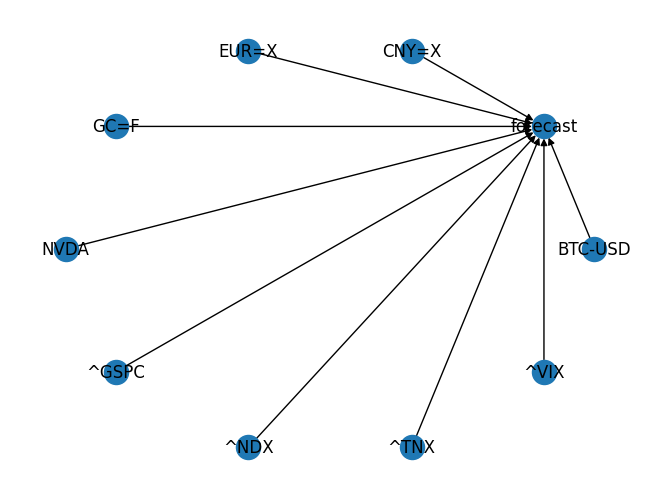

In [401]:
########## Constructing sample knowledge graph of Belief Network #####
 
my_edges = []
for col in c_data.columns:
    if col == 'forecast':
        pass
    else:
        my_edges.append((col,'forecast'))


### Sample prior knowledge graph
print("possible edges will be:",my_edges)

##### Contructing Prior Graph Image using NetworkX ####
G=nx.DiGraph()
G.add_edges_from(my_edges)
label_dict = {}
for node in G.nodes():
    label_dict[node] = node
pos = nx.spring_layout(G);
# nx.draw_networkx_nodes(G, pos, node_size = 10)
# nx.draw_networkx_edges(G, pos, arrows=True)
# nx.draw_networkx_labels(G,pos,labels=label_dict,)
nx.draw_circular(G,labels=label_dict,)
plt.show()

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned bayesian structure edges are:
 [('BTC-USD', '^TNX'), ('BTC-USD', '^VIX'), ('CNY=X', 'forecast'), ('CNY=X', 'EUR=X'), ('EUR=X', 'forecast'), ('GC=F', 'forecast'), ('NVDA', '^NDX'), ('^GSPC', '^VIX'), ('^GSPC', '^TNX'), ('^NDX', 'forecast'), ('^NDX', '^GSPC'), ('^NDX', '^TNX'), ('^NDX', '^VIX'), ('^TNX', 'GC=F')]


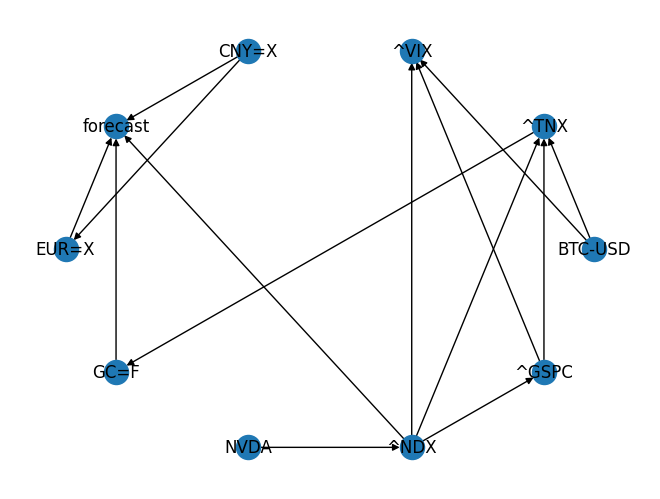

In [402]:
############ Appliying hillclimb search to best Bayesian network ###########
################## If some prior structure is known ########################

edges = my_edges ## Feeding the prior knowledge graph

train_df = c_data.iloc[:,:] ### TRAINING WITH COMPLETE DATA 

model = BayesianNetwork()
model.add_nodes_from(nodes=list(train_df.columns))
model.add_edges_from(edges)

hc = HillClimbSearch(train_df,state_names=dict(map(lambda e: (e, [0, 1]), train_df),node_names=list(train_df.columns)))
k2 = K2Score(train_df)
learned_model = hc.estimate(start_dag=model,scoring_method=k2)

print("Learned bayesian structure edges are:\n",learned_model.edges())

##### Fitting the Data into Learned Model ###############
learned_model.fit(train_df,state_names=dict(map(lambda e: (e, [0, 1]), train_df.columns)),
                  estimator=BayesianEstimator, prior_type="K2")

######## Drawing the network ######################
# plt.figure(figsize=(14,6))
H=nx.DiGraph()
H.add_edges_from(learned_model.edges())
H.add_nodes_from(learned_model.nodes())
label_dict = {}
for node in H.nodes():
    label_dict[node] = node
pos = nx.spring_layout(H)
# nx.draw_networkx_nodes(H, pos, node_size = 10)
# nx.draw_networkx_edges(H, pos, arrows=True)
# nx.draw_networkx_labels(H,pos,labels=label_dict,)
nx.draw_circular(H,labels=label_dict,)
plt.show()

In [403]:
H.edges()

OutEdgeView([('BTC-USD', '^TNX'), ('BTC-USD', '^VIX'), ('^TNX', 'GC=F'), ('CNY=X', 'forecast'), ('CNY=X', 'EUR=X'), ('EUR=X', 'forecast'), ('GC=F', 'forecast'), ('NVDA', '^NDX'), ('^NDX', 'forecast'), ('^NDX', '^GSPC'), ('^NDX', '^TNX'), ('^NDX', '^VIX'), ('^GSPC', '^VIX'), ('^GSPC', '^TNX')])

In [404]:
# print(mom)

In [405]:
### Optimal Belief Network Configurations #########

print('Nodes of the model:',learned_model.nodes())
print('Edges of the model:',learned_model.edges())

#### Printing CPD table of the dataset ###########
for model in learned_model.get_cpds():
    print("\n\nThe CPD table is:\n",model)


Nodes of the model: ['BTC-USD', 'CNY=X', 'EUR=X', 'GC=F', 'NVDA', '^GSPC', '^NDX', '^TNX', '^VIX', 'forecast']
Edges of the model: [('BTC-USD', '^TNX'), ('BTC-USD', '^VIX'), ('CNY=X', 'forecast'), ('CNY=X', 'EUR=X'), ('EUR=X', 'forecast'), ('GC=F', 'forecast'), ('NVDA', '^NDX'), ('^GSPC', '^VIX'), ('^GSPC', '^TNX'), ('^NDX', 'forecast'), ('^NDX', '^GSPC'), ('^NDX', '^TNX'), ('^NDX', '^VIX'), ('^TNX', 'GC=F')]


The CPD table is:
 +------------+----------+
| BTC-USD(0) | 0.626016 |
+------------+----------+
| BTC-USD(1) | 0.373984 |
+------------+----------+


The CPD table is:
 +----------+----------+
| CNY=X(0) | 0.430894 |
+----------+----------+
| CNY=X(1) | 0.569106 |
+----------+----------+


The CPD table is:
 +----------+---------------------+--------------------+
| CNY=X    | CNY=X(0)            | CNY=X(1)           |
+----------+---------------------+--------------------+
| EUR=X(0) | 0.6481481481481481  | 0.4084507042253521 |
+----------+---------------------+----------------

In [406]:
#### QuantumCircuit initialization ####
node_list = list(learned_model.nodes())
cr = ClassicalRegister(1,'signal')
qc= QuantumCircuit([]) #,cr)

for node in node_list:
    qc.add_register(QuantumRegister(1,node)) # Adding qubits with names same as nodes


data_qc = qc.copy()
model_qc = qc.copy()
######### Contructing the QBN from available CPD and ###### 
######### the Learned Belief Network Structure       #######
for i in range(len(learned_model.get_cpds())):
    my_model = learned_model.get_cpds()[i]
    print('\n\nModel state space:',my_model.state_names)



    if len(my_model.variables) == 1:
        cpd = pd.DataFrame(my_model.get_values(),columns=['Probs']).rename_axis(my_model.variable,axis=1)
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Probs'].iloc[0]/cpd['Probs'].iloc[1]))
        print(cpd)

        data_qc.ry(prob_to_angle(my_model.values[1]),node_list.index(my_model.variable))
    else:
        print('Control:',my_model.variables[1:],'-----------> Target:',my_model.variable)

        lst = np.array(list(itertools.product([0, 1], repeat=len(my_model.variables)-1)))
        cpd = pd.DataFrame(np.array(lst),columns = my_model.variables[1:])
        cpd['Prob_'+ my_model.variable + str(0)] = my_model.get_values()[0,:]
        cpd['Prob_'+ my_model.variable + str(1)] = my_model.get_values()[1,:]
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Prob_'+ my_model.variable + str(0)]/cpd['Prob_'+ my_model.variable + str(1)]))
        print(cpd)

        for j in range(cpd.shape[0]):
            ctrls = [str(int(z)) for z in cpd.iloc[j,:-3].values]
            ctrls = ''.join(ctrls)
            # print("The control state is",ctrls)
            model_qc = custom_mcry(model_qc,cpd.iloc[j,-1],[node_list.index(j) for j in my_model.variables[1:]],node_list.index(my_model.variable),ctrls)

    model_qc.barrier()

# qc.measure_all()
# qc.draw('mpl',fold=60)



Model state space: {'BTC-USD': [0, 1]}
BTC-USD     Probs     theta
0        0.626016  1.825576
1        0.373984  1.825576


Model state space: {'CNY=X': [0, 1]}
CNY=X     Probs     theta
0      0.430894  1.432141
1      0.569106  1.432141


Model state space: {'EUR=X': [0, 1], 'CNY=X': [0, 1]}
Control: ['CNY=X'] -----------> Target: EUR=X
   CNY=X  Prob_EUR=X0  Prob_EUR=X1     theta
0      0     0.648148     0.351852  1.871609
1      1     0.408451     0.591549  1.386659


Model state space: {'GC=F': [0, 1], '^TNX': [0, 1]}
Control: ['^TNX'] -----------> Target: GC=F
   ^TNX  Prob_GC=F0  Prob_GC=F1     theta
0     0    0.327869    0.672131  1.219343
1     1    0.640625    0.359375  1.855893


Model state space: {'NVDA': [0, 1]}
NVDA     Probs    theta
0     0.463415  1.49756
1     0.536585  1.49756


Model state space: {'^GSPC': [0, 1], '^NDX': [0, 1]}
Control: ['^NDX'] -----------> Target: ^GSPC
   ^NDX  Prob_^GSPC0  Prob_^GSPC1     theta
0     0     0.852459     0.147541  2.353104

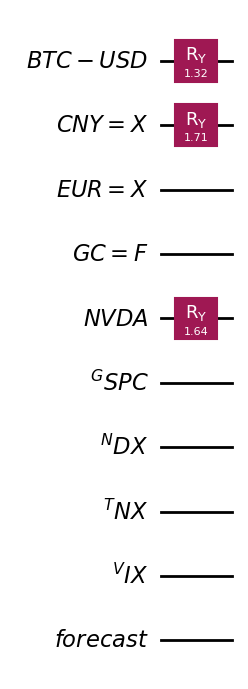

In [407]:
data_qc.draw('mpl')

In [408]:
print("Depth of the circuit is:",model_qc.depth())
print("2 qubit gate operations is:\n",model_qc.count_ops())
# model_qc.draw('mpl',fold=200)

Depth of the circuit is: 371
2 qubit gate operations is:
 OrderedDict([('x', 120), ('cx', 112), ('cu', 112), ('ccx', 64), ('unitary', 64), ('ry', 16), ('barrier', 10)])


In [409]:
#### Combine the circuit ##############33
qbn_qc = data_qc.compose(model_qc,qubits = range(model_qc.num_qubits))
qbn_qc.measure_all()
# qbn_qc.draw('mpl',fold=200)

In [410]:
##### Running on simulator #####
backend = AerSimulator()

# pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
# isa_circuit = pm.run(qbn_qc)

# print("Original Circuit depth is",qbn_qc.depth())
# print("Transpiled Cicuit depth is",isa_circuit.depth())


with Session(service, backend = backend) as session:
    sampler = Sampler(session=session)

    job = sampler.run(qbn_qc, shots=1000)
    result = job.result()
    binary_data = result.quasi_dists[0].binary_probabilities()
    print(f"Job result: {binary_data}")

/tmp/ipykernel_14007/221029382.py:12: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)
base_primitive._run_primitive:INFO:2024-07-17 16:54:10,422: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.34954 (

Job result: {'0000000110': 0.001, '1000100110': 0.001, '1111110011': 0.002, '0111110101': 0.001, '1100100110': 0.001, '1001111001': 0.001, '1001010001': 0.001, '1111001010': 0.001, '0101001011': 0.001, '0100100100': 0.001, '1011011100': 0.001, '1110010010': 0.001, '1100101010': 0.001, '1001000001': 0.001, '1101000000': 0.001, '0111011010': 0.001, '0110100000': 0.001, '1111000111': 0.001, '1100110000': 0.001, '1010010010': 0.001, '1000110101': 0.001, '1000110011': 0.001, '0010111010': 0.001, '1001100001': 0.001, '1001010010': 0.001, '1001100000': 0.001, '0000011100': 0.001, '1001001001': 0.001, '0000100110': 0.001, '1000101010': 0.001, '0100110000': 0.001, '1000100000': 0.002, '1000000010': 0.001, '0010101100': 0.001, '0010110110': 0.003, '1111101110': 0.002, '1000011100': 0.001, '1011010011': 0.001, '1101110100': 0.001, '1000111001': 0.001, '1101100101': 0.001, '0101100001': 0.002, '1111111001': 0.002, '1110100000': 0.001, '1010111010': 0.001, '0111110011': 0.002, '0110111010': 0.003, 

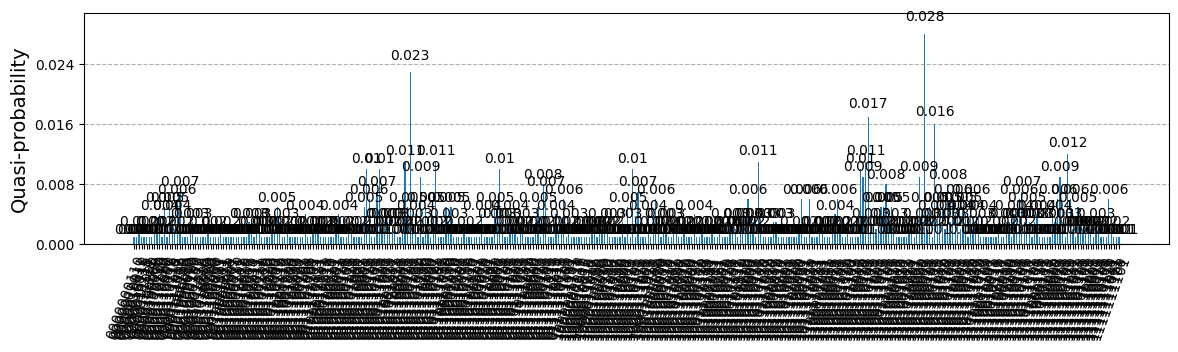

In [411]:
######## Plotting the distribution #############
plot_histogram(binary_data,figsize=(14,3))

In [412]:
# q_data['forecast'] = data[target].apply(lambda x: 1 if x >= 0 else 0).shift(-1) #.apply(np.int64)
q_data['forecast'] = c_data['forecast']
q_data.dropna(inplace=True)
q_data['forecast'] = q_data['forecast'].apply(np.int64)
q_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,GC=F,NVDA,^GSPC,^NDX,^TNX,^VIX,forecast
Date,,,,,,,,,,
2019-01-03,1.496000,1.566046,1.596036,1.586043,1.445697,1.518592,1.500339,1.494737,1.766322,0
2019-01-04,1.561104,1.573730,1.557845,1.555091,1.695314,1.636849,1.657359,1.657564,1.247560,1
2019-01-07,1.637073,1.570029,1.567262,1.575573,1.672916,1.582150,1.588025,1.592533,1.574873,0
2019-01-08,1.552951,1.565457,1.558585,1.563585,1.517041,1.587520,1.587208,1.600590,1.485985,0
2019-01-09,1.552376,1.571458,1.574790,1.578688,1.606198,1.576325,1.582511,1.584068,1.525111,0


In [413]:
def encode_data(train_row): # Encoding angle data to quantum circuit Ry gates
    quantum_data = QuantumCircuit(train_row.shape[0],1)
    for j in range(len(train_row)):
        quantum_data.ry(train_row[j],j)

    quantum_data.barrier()
    return quantum_data


def Signal(result,price):
    info_dict = {0:-1,1:1}
    state = list(result.quasi_dists[0].keys())[0]
    diff = result.quasi_dists[0][1] - result.quasi_dists[0][0]
    if abs(diff) > 0.1:
        signal = info_dict[state]
        if signal == 1:  
            buy_price = price
            sell_price = np.nan
        elif signal == -1:
            buy_price = np.nan
            sell_price = price       
    else:
        signal = 0
        buy_price = np.nan
        sell_price = np.nan  
    return signal, buy_price, sell_price, state

In [414]:
aer_sim = AerSimulator()
session = Session(backend=aer_sim)
options = Options()
options.execution.shots = 100
options.transpilation.skip_transpilation = True
options.optimization_level = 0
options.resilience_level = 0

all_signals = []
STATES = []
BUY_PRICE = []
SELL_PRICE = []

cr = ClassicalRegister(1)
model_qc.add_register(cr)

z = 90

for i in range(z,q_data.shape[0]):
    price = data0.iloc[i+1,0]
    row = np.append(q_data.iloc[i,:-1].values,0)
    my_data = encode_data(row) #data.iloc[i,:].values)
    my_data.append(model_qc,qargs=range(q_data.iloc[i,:].values.shape[0]),cargs=[0])
    my_data.measure(-1,0)
    
    

    with Session(service, backend = backend) as session:
        sampler = Sampler(session=session)
        result = sampler.run(my_data,shots=100).result()
    # val_signal = list(result.quasi_dists[0].keys())[0]
    val_signal,buy_price, sell_price, state = Signal(result,price)
    all_signals.append(val_signal)
    BUY_PRICE.append(buy_price)
    SELL_PRICE.append(sell_price)
    STATES.append(state)
    print("\n\nThe position of the next day:",i,"is:",val_signal,result.quasi_dists[0])

/tmp/ipykernel_14007/1472645332.py:29: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(session=session)
base_primitive._run_primitive:INFO:2024-07-17 16:54:18,106: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02623 (



The position of the next day: 90 is: -1 {0: 0.45, 1: 0.55}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.16803 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.58985 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.58317 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 35.32505 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.38776 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.21994 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.27196 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.66996 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01812 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 257.14684 (ms)
base_primitive._run_primitive:INFO:2024-



The position of the next day: 91 is: 0 {1: 0.54, 0: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 93.87112 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.59876 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 13.41677 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.69842 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.61941 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 77.58498 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.80540 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.33073 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.44982 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.57197 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager



The position of the next day: 92 is: -1 {0: 0.41, 1: 0.59}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.74005 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03934 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 25.79570 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.58215 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.34408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.60749 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.59366 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03982 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 212.93402 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:19,530: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpila



The position of the next day: 93 is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 35.75373 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.63405 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.88696 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.17779 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.50902 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03910 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 216.24923 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:19,806: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m



The position of the next day: 94 is: -1 {0: 0.32, 1: 0.68}


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.48869 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.65947 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 201.75958 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:20,092: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.11563



The position of the next day: 95 is: -1 {0: 0.44, 1: 0.56}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 56.48422 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.57819 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.25968 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.15967 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.54400 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 250.15259 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:20,484: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m



The position of the next day: 96 is: 1 {1: 0.6, 0: 0.4}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 68.09378 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('x', 1), ('cx', 2), ('barrier', 10), ('ry', 1), ('unitary', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1',



The position of the next day: 97 is: 0 {0: 0.48, 1: 0.52}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 42.02628 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.51293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.16343 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.02472 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.70190 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03743 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 229.45428 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:21,386: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m



The position of the next day: 98 is: -1 {0: 0.55, 1: 0.45}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 8.22973 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.29747 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.59056 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 37.89520 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.74730 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.16598 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.38569 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.63348 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 260.83755 (ms)
base_primitive._run_primitive:INFO:2024-



The position of the next day: 99 is: -1 {0: 0.37, 1: 0.63}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.09745 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 15.69366 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.45245 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.57673 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02527 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 241.58072 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:22,119: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}



The position of the next day: 100 is: 0 {1: 0.53, 0: 0.47}


INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 51.19419 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('x', 1), ('cx', 2), ('barrier', 10), ('ry', 1), ('unitary', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'm



The position of the next day: 101 is: 1 {1: 0.55, 0: 0.45}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 26.50785 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.30074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 7.64632 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.48916 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.50759 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 231.76765 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:22,932: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m



The position of the next day: 102 is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 37.90331 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.65384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.36983 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.33896 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.66590 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02503 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 233.58464 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:23,230: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m



The position of the next day: 103 is: -1 {0: 0.32, 1: 0.68}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.53358 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 202.11077 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:23,508: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesi



The position of the next day: 104 is: 0 {1: 0.54, 0: 0.46}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 75.63210 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.63166 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.31197 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.29151 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.49758 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 35.06136 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.69723 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.07498 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.17826 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.55480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02670 (ms)
INFO:qiskit.passmanager.



The position of the next day: 105 is: 1 {1: 0.55, 0: 0.45}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.95907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.24185 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.89991 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.12510 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.46992 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 33.90241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.19226 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.94306 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.18566 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.48280 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02909 (ms)
INFO:qiskit.passmanager.



The position of the next day: 106 is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 72.90173 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.52604 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 13.82208 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.17803 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.59772 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 82.84187 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.38919 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.95395 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.29271 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.88143 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02480 (ms)
INFO:qiskit.passmanager



The position of the next day: 107 is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 38.31744 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.38466 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.59235 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.23572 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.67258 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 222.43428 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:25,099: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m



The position of the next day: 108 is: -1 {0: 0.34, 1: 0.66}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 65.35912 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.79379 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.49722 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.57571 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.55695 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 42.31119 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.57764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 9.27472 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.58923 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.55337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02789 (ms)
INFO:qiskit.passmanager.



The position of the next day: 109 is: -1 {0: 0.41, 1: 0.59}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 92.12565 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.47169 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.98161 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.71645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.21062 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 25.80786 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.43664 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 2.67434 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.22309 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.44935 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02527 (ms)
INFO:qiskit.passmanager.



The position of the next day: 110 is: 0 {0: 0.47, 1: 0.53}


INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.77176 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.31288 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:26,234: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevel



The position of the next day: 111 is: 1 {1: 0.57, 0: 0.43}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 30.05147 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.14059 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.00584 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.39666 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.63658 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 226.72725 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:26,526: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_m



The position of the next day: 112 is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 86.10177 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('x', 1), ('cx', 2), ('barrier', 10), ('ry', 1), ('unitary', 1)} to target basis {'initialize', 'ccx', 'sxdg', 'save_statevector', 'h', 'save_stabilizer', 'cz', 'store', 'rxx', 'u1', 'break_loop', 'save_superop', 'id', 'cu', 'kraus', 'cp', 'set_superop', 'cu1', 'save_state', 'mcu3', 'crz', 'mcsx', 'x', 'set_unitary', 'for_loop', 'save_unitary', 'cswap', 'ry', 'ryy', 'set_stabilizer', 'mcrx', 'mcswap', 'cry', 'mcphase', 'save_matrix_product_state', 'set_matrix_product_state', 'cx', 'set_statevector', 'swap', 'sdg', 'cy', 'pauli', 'save_probabilities_dict', 'while_loop', 'sx', 'rzx', 'superop', 'mcu2', 'mcrz', 'mcry', 'mcx', 'crx', 's', 'reset', 'rzz', 'barrier', 'continue_loop', 'save_density_matrix', 'rx', 'mcz', 'csx', 'measure', 'r', 'snapshot', 'if_else', 'multiplexer', 'mcu1',



The position of the next day: 113 is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02694 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 192.57045 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:27,408: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.04053 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 22.02129 (ms)
INFO:qiskit.transpiler.passes.basis



The position of the next day: 114 is: -1 {0: 0.37, 1: 0.63}


INFO:qiskit.compiler.transpiler:Total Transpile Time - 189.65960 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:27,661: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.02551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 24.98460 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('cu', 2), ('measure', 1), ('ccx', 3), ('x', 1), ('cx', 2), ('barrier', 10), ('ry', 



The position of the next day: 115 is: 1 {1: 0.59, 0: 0.41}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.43187 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.18339 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.44267 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.64659 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.06795 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 199.11122 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:27,925: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
I



The position of the next day: 116 is: -1 {0: 0.4, 1: 0.6}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.65787 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.27134 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.90158 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.31321 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.53692 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 37.21809 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.58279 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 6.28924 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.36304 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.57912 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.05746 (ms)
INFO:qiskit.passmanager.



The position of the next day: 117 is: 1 {1: 0.56, 0: 0.44}


INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 46.56076 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.38729 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.01728 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.29366 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.71001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 33.40816 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.48289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 5.87583 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.31202 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.54812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.



The position of the next day: 118 is: 1 {1: 0.58, 0: 0.42}


INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 4.92668 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 1.24407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.52047 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01860 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 199.22185 (ms)
base_primitive._run_primitive:INFO:2024-07-17 16:54:29,000: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02623 (ms)
I



The position of the next day: 119 is: 1 {1: 0.58, 0: 0.42}


INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02551 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 193.37344 (ms)




The position of the next day: 120 is: 1 {1: 0.57, 0: 0.43}


In [415]:
print("Signals:",np.array(all_signals))
print("States :",np.array(STATES))
print("Forecast:",q_data.iloc[z:,-1].values)

Signals: [-1  0 -1 -1 -1 -1  1  0 -1 -1  0  1 -1 -1  0  1 -1  1 -1 -1  0  1 -1 -1
 -1  1 -1  1  1  1  1]
States : [0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1]
Forecast: [1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1]


In [416]:
all_trades = []
b_price = []
s_price = []
for i in range(1,len(STATES)):
    if STATES[i] > STATES[i-1]:
        all_trades.append(+1)
        b_price.append(data0.iloc[z+i,0])
        s_price.append(np.nan)
    elif STATES[i] < STATES[i-1]:
        all_trades.append(-1)
        b_price.append(np.nan)
        s_price.append(data0.iloc[z+i,0])
    else:
        all_trades.append(0)
        b_price.append(np.nan)
        s_price.append(np.nan)

print(np.array(all_trades))


[ 1 -1  0  0  0  1 -1  0  0  1  0 -1  0  1  0 -1  1 -1  0  0  1 -1  0  0
  1 -1  1  0  0  0]


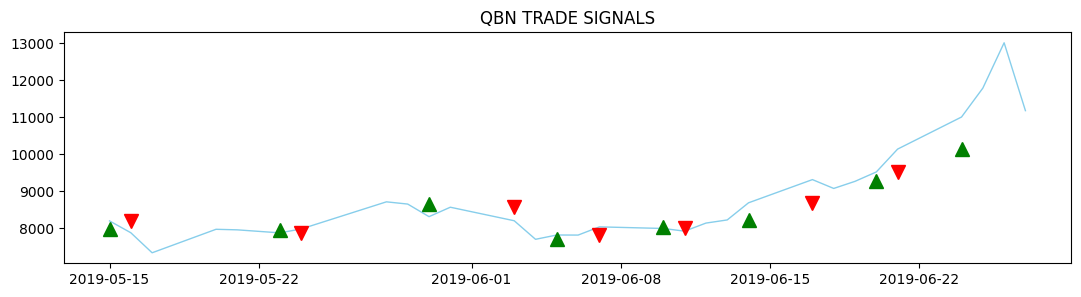

In [417]:
stock_prices = data0.loc[q_data.index].iloc[1+z:,0]

plt.figure(figsize=(13,3))
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = target)
plt.plot(stock_prices.index, b_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, s_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.title('QBN TRADE SIGNALS')
plt.show()

/home/aniruddha/miniconda3/envs/capstone_env1/lib/python3.10/site-packages/pyfolio/plotting.py:650: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-41.5%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100,


Start date,2019-05-15
End date,2019-06-27
Total months,1
,Backtest
Annual return,-41.5%
Cumulative returns,-6.2%
Annual volatility,82.0%
Sharpe ratio,-0.28
Calmar ratio,-3.23
Stability,0.10
Max drawdown,-12.8%


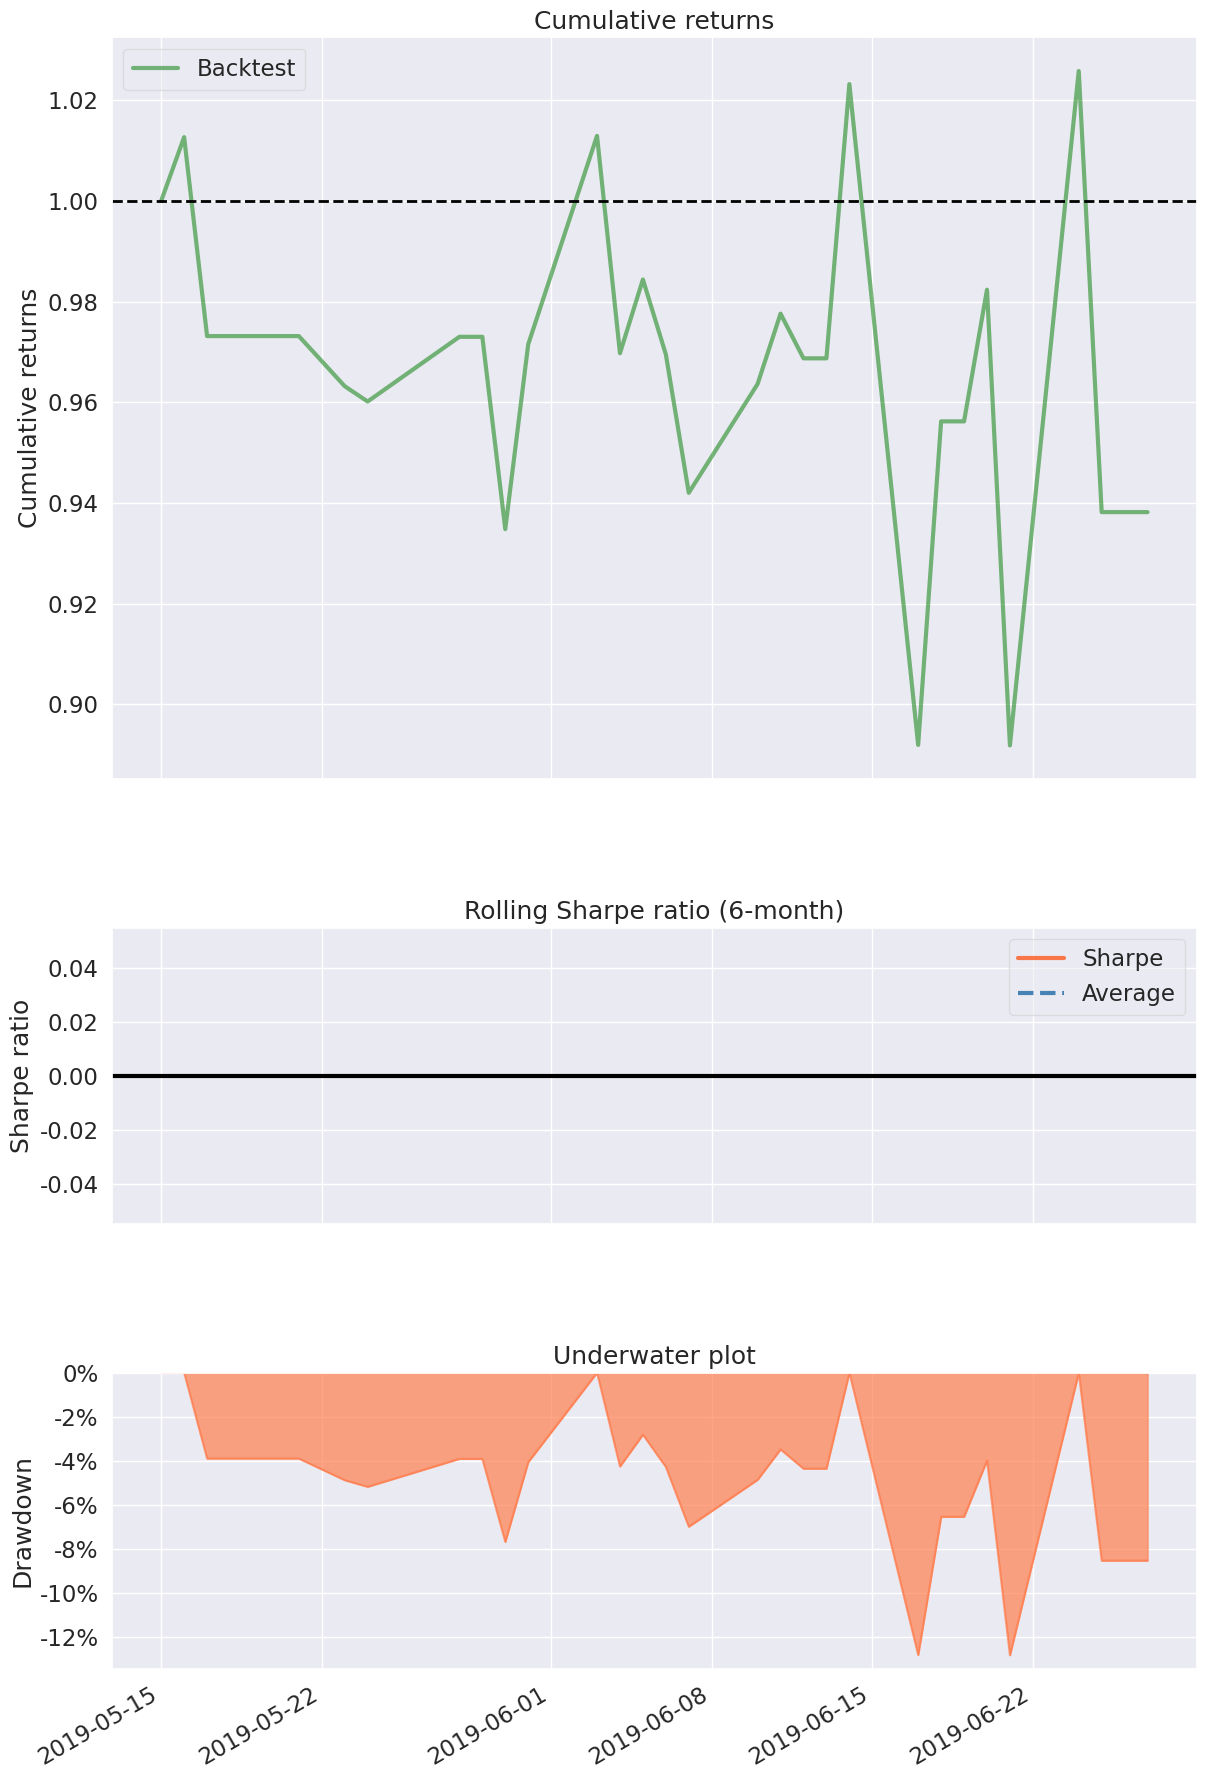

In [418]:
strategy_returns = data.loc[q_data.index].iloc[z+1:,0]*np.array(all_trades)
pf.create_simple_tear_sheet(strategy_returns.diff())

<Axes: xlabel='Date'>

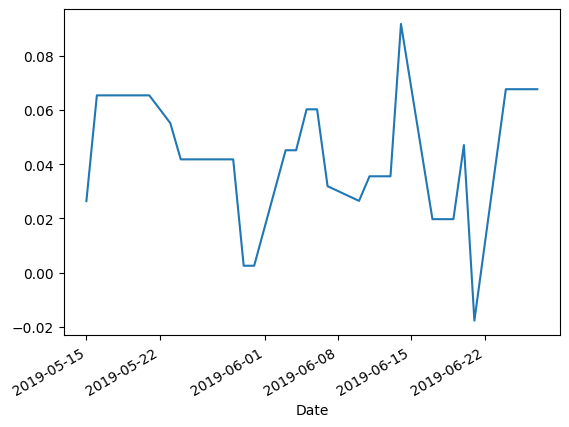

In [419]:
strategy_returns.cumsum().plot()

<Axes: xlabel='Date'>

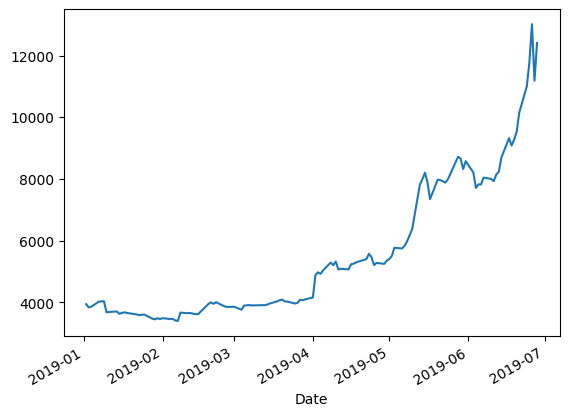

In [420]:
data0['BTC-USD'].plot()